# Assignment 3: Hierarchical Clustering Algorithm 

## 导入数据集

在这边我选用的是经典的鸢尾花数据集。（https://archive.ics.uci.edu/dataset/53/iris ）
这是一个有标签的分类的数据集，但是我们可以不用他的标签，来对自己写的聚类算法做实验。

In [1]:
from ucimlrepo import fetch_ucirepo 
# fetch dataset 
iris = fetch_ucirepo(id=53) 
# data (as pandas dataframes) 
X = iris.data.features 
y = iris.data.targets 
# metadata 
print(iris.metadata) 
# variable information 
print(iris.variables) 

{'uci_id': 53, 'name': 'Iris', 'repository_url': 'https://archive.ics.uci.edu/dataset/53/iris', 'data_url': 'https://archive.ics.uci.edu/static/public/53/data.csv', 'abstract': 'A small classic dataset from Fisher, 1936. One of the earliest known datasets used for evaluating classification methods.\n', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 150, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1936, 'last_updated': 'Tue Sep 12 2023', 'dataset_doi': '10.24432/C56C76', 'creators': ['R. A. Fisher'], 'intro_paper': {'title': 'The Iris data set: In search of the source of virginica', 'authors': 'A. Unwin, K. Kleinman', 'published_in': 'Significance, 2021', 'year': 2021, 'url': 'https://www.semanticscholar.org/paper/4599862ea877863669a6a8e63a3c707a787d5d7e', 'doi': '1740-9713.01589'}, 'add

In [2]:
X

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [3]:
y

,class
0,Iris-setosa
1,Iris-setosa
2,Iris-setosa
3,Iris-setosa
4,Iris-setosa
...,...
145,Iris-virginica
146,Iris-virginica
147,Iris-virginica
148,Iris-virginica


In [4]:
import numpy as np
num_classes = len(np.unique(y))
print("总共有", num_classes, "个不同的类别。")
np.unique(y)

总共有 3 个不同的类别。


array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [5]:
classes = y['class'].unique()  # 获取所有不同的类别
class_id_dict = {class_: [] for class_ in classes}  # 创建一个字典，键是类别，值是对应的ID数组
for idx, class_ in enumerate(y['class']):
    class_id_dict[class_].append(idx)  # 将相同类别的 ID 放入对应的数组中
print(class_id_dict)

{'Iris-setosa': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'Iris-versicolor': [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'Iris-virginica': [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]}


## 导入我写的层次聚类的类

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

class HierarchicalClustering:
    def __init__(self, n_clusters=2, linkage='single', distance_method='Euclidean'):
        self.n_clusters = n_clusters  # 期望分成的簇的个数
        self.linkage = linkage        # 链接方式选择
        self.distance_method=distance_method #距离计算方法
        self.cluster_points = []  # 初始化簇
        self.distances_dict = {}  # 初始化距离矩阵字典
        self.link=[]              #链接矩阵
        self.time=0
    
    def fit(self, X):
        start_time = time.time()
        n_samples, _ = X.shape
        self.labels_ = np.zeros(n_samples)
        
        distances = np.zeros((n_samples, n_samples))
        self.cluster_points = [[i] for i in range(n_samples)]  # 每个点为一个簇
        # 初始化簇和距离矩阵字典
        # print(self.cluster_points)

        #计算距离矩阵字典
        for i in range(n_samples):
            for j in range(n_samples):
                distances[i][j] = self.calculate_distance(X[i], X[j])
        # print(distances)
        # 将距离矩阵转换为压缩形式
        condensed_distances = squareform(distances)
        self.link = linkage(condensed_distances, method=self.linkage)  # 此处的distances是您计算的距离矩阵
        
        #进行聚类
        for _ in range(n_samples - self.n_clusters):

            #先寻找距离最短的两个簇
            min_distance = np.inf
            for b in range(n_samples):
                for c in range(b+1, n_samples):
                    if distances[b][c] < min_distance:
                        min_distance = distances[b][c]
                        min_i = b  #将距离最短的这两个簇给记下来
                        min_j = c
            # 先对存储簇的ID的数组给处理了
            self.cluster_points[min_i].extend(self.cluster_points[min_j])  # 将第min_j行合并到上面的min_i
            del self.cluster_points[min_j]  # 然后将min_j行删掉

            # print(self.cluster_points)
            
            # 更新距离字典
            for i in range(n_samples):
                if i != min_i and i != min_j:
                    if self.linkage == 'single':
                        distances[min_i, i] = min(distances[min_i, i], distances[min_j, i])
                    elif self.linkage == 'complete':
                        distances[min_i, i] = max(distances[min_i, i], distances[min_j, i])
                    elif self.linkage == 'average':
                        distances[min_i, i] = (distances[min_i, i] + distances[min_j, i]) / 2            
            # print(distances)

            distances = np.delete(distances, min_j, axis=0)
            distances = np.delete(distances, min_j, axis=1)
            # print(distances)

            n_samples -= 1  # 更新样本数量
        
        # 根据簇的合并情况得到最终的标签
        self.labels_ = self.get_labels(self.distances_dict)
        # 对每个簇中的ID进行排序
        for i in range(len(self.cluster_points)):
            self.cluster_points[i].sort()

        end_time = time.time()
        self.time = end_time - start_time
        
        return self.cluster_points

    # 运用距离公式计算距离   
    def calculate_distance(self, x1, x2):
        if self.distance_method == 'Manhattan':
            return np.linalg.norm(x1 - x2, ord=1)  # 曼哈顿距离
        elif self.distance_method == 'Chebyshev':
            return np.linalg.norm(x1 - x2, ord=np.inf)  # 切比雪夫距离
        elif self.distance_method == 'Euclidean':
            return np.linalg.norm(x1 - x2)  #欧氏距离
    
    def get_labels(self, distances_dict):
        n_samples = len(distances_dict)
        labels = np.zeros(n_samples)
        current_label = 0
        cluster_dict = {}
        
        for i, distances in distances_dict.items():
            if i not in cluster_dict:
                cluster_dict[i] = current_label
                current_label += 1
            
            for j, dist in distances.items():
                if dist == 0:
                    if j not in cluster_dict:
                        cluster_dict[j] = cluster_dict[i]
                    else:
                        for k, v in cluster_dict.items():
                            if v == cluster_dict[j]:
                                cluster_dict[k] = cluster_dict[i]
                    break
        
        for i in range(n_samples):
            labels[i] = cluster_dict[i]

        return labels.astype(int)

    # 聚类结果可视化
    def plot_clusters(self, X,x_label,y_label,title):
        colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # 创建一个子图

        # 绘制聚类结果散点图
        for i, cluster in enumerate(self.cluster_points):
            cluster_color = colors[i % len(colors)]
            cluster_data = X[cluster]
            ax.scatter(cluster_data[:, 0], cluster_data[:, 1], c=cluster_color, label=f'Cluster {i}')
        ax.legend()
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title)

        plt.show()

### 对四维数据进行聚类

对鸢尾花数据集的数据进行处理。
将其转换成数组进行输出。

In [7]:
import numpy as np

# 假设 df 是你的 DataFrame
X_array = X.values
X_array

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

#### 使用Euclidean距离公式进行计算

##### Single-linkage + Euclidean

In [8]:
model_single_euclidean = HierarchicalClustering(n_clusters=3, linkage='single')
cluster_single_euclidean = model_single_euclidean.fit(X_array)
print(cluster_single_euclidean)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149], [117, 131]]


In [9]:
import pandas as pd

# 定义类别标签映射
label_mapping = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}

# 创建一个空的 DataFrame
y_single_euclidean = pd.DataFrame(columns=['Class'])

# 遍历 cluster_points，给每个 ID 分配对应的类别
for i, cluster in enumerate(cluster_single_euclidean):
    for id in cluster:
        y_single_euclidean.loc[id] = label_mapping[i]

# 显示结果
print(y_single_euclidean)


               Class
0        Iris-setosa
1        Iris-setosa
2        Iris-setosa
3        Iris-setosa
4        Iris-setosa
..               ...
147  Iris-versicolor
148  Iris-versicolor
149  Iris-versicolor
117   Iris-virginica
131   Iris-virginica

[150 rows x 1 columns]


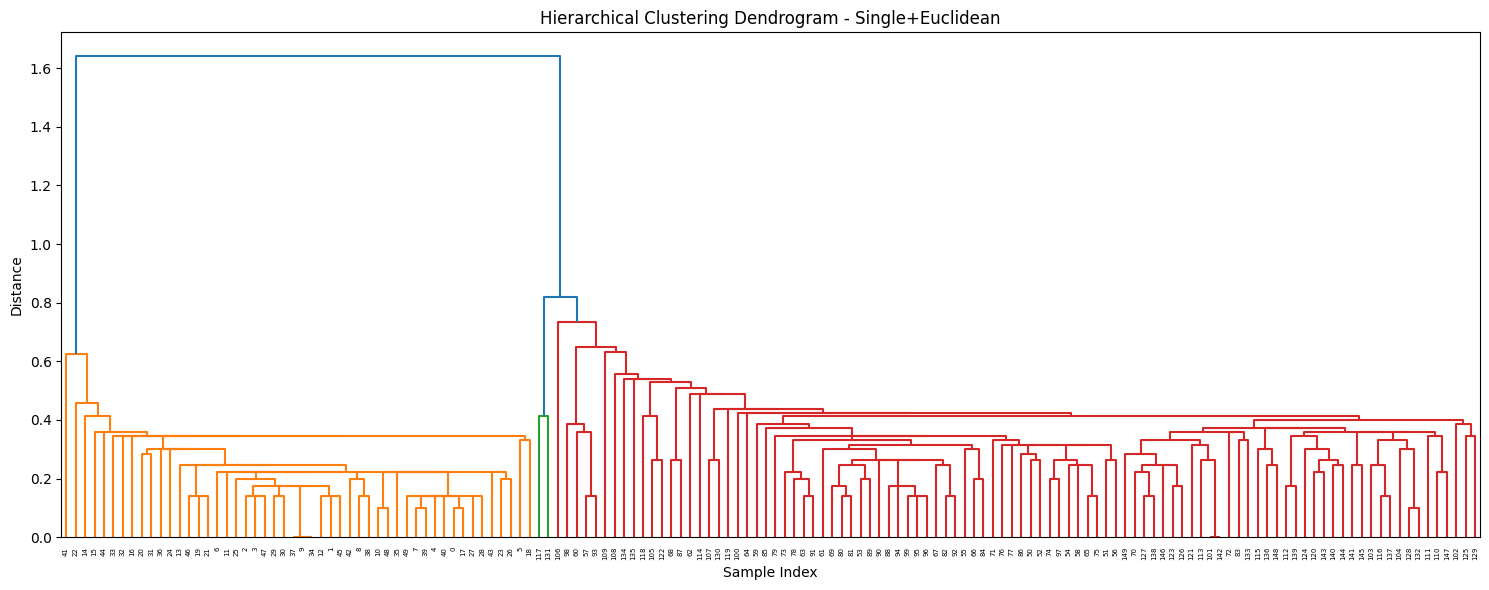

In [10]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
axs = plt.subplots(figsize=(15, 6))
# 绘制树状图
dendrogram(model_single_euclidean.link, ax=axs[1],color_threshold=model_single_euclidean.link[-(model_single_euclidean.n_clusters - 1), 2])
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Distance')
axs[1].set_title('Hierarchical Clustering Dendrogram - Single+Euclidean')

plt.tight_layout()
plt.show()

##### Complete-linkage + Euclidean

In [11]:
model_complete_euclidean = HierarchicalClustering(n_clusters=3, linkage='complete')
cluster_complete_euclidean = model_complete_euclidean.fit(X_array)
print(cluster_complete_euclidean)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 106, 110, 113, 114, 115, 119, 121, 123, 126, 127, 133, 138, 141, 142, 145, 147, 149], [100, 102, 103, 104, 105, 107, 108, 109, 111, 112, 116, 117, 118, 120, 122, 124, 125, 128, 129, 130, 131, 132, 134, 135, 136, 137, 139, 140, 143, 144, 146, 148]]


In [12]:
import pandas as pd

# 定义类别标签映射
label_mapping = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}

# 创建一个空的 DataFrame
y_complete_euclidean = pd.DataFrame(columns=['Class'])

# 遍历 cluster_points，给每个 ID 分配对应的类别
for i, cluster in enumerate(cluster_complete_euclidean):
    for id in cluster:
        y_complete_euclidean.loc[id] = label_mapping[i]

# 显示结果
print(y_complete_euclidean)

              Class
0       Iris-setosa
1       Iris-setosa
2       Iris-setosa
3       Iris-setosa
4       Iris-setosa
..              ...
140  Iris-virginica
143  Iris-virginica
144  Iris-virginica
146  Iris-virginica
148  Iris-virginica

[150 rows x 1 columns]


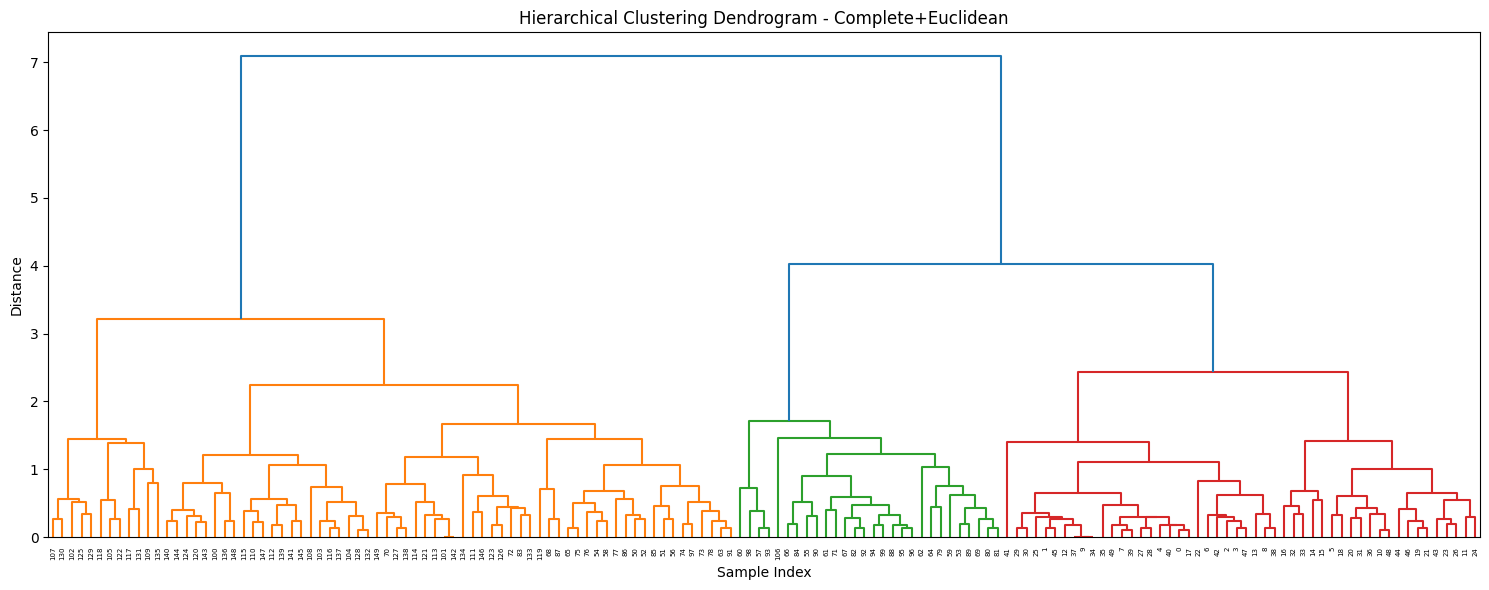

In [13]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
axs = plt.subplots(figsize=(15, 6))
# 绘制树状图
dendrogram(model_complete_euclidean.link, ax=axs[1],color_threshold=model_complete_euclidean.link[-(model_complete_euclidean.n_clusters - 1), 2])
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Distance')
axs[1].set_title('Hierarchical Clustering Dendrogram - Complete+Euclidean')

plt.tight_layout()
plt.show()

##### Average-linkage + Euclidean

In [14]:
model_average_euclidean = HierarchicalClustering(n_clusters=3, linkage='average')
cluster_average_euclidean = model_average_euclidean.fit(X_array)
print(cluster_average_euclidean)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 54, 56, 58, 65, 74, 75, 76, 77, 85, 86, 97, 100, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 115, 116, 117, 118, 120, 122, 124, 125, 128, 129, 130, 131, 132, 134, 135, 136, 137, 139, 140, 141, 143, 144, 145, 147, 148], [53, 55, 57, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 78, 79, 80, 81, 82, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 101, 106, 113, 114, 119, 121, 123, 126, 127, 133, 138, 142, 146, 149]]


In [15]:
import pandas as pd

# 定义类别标签映射
label_mapping = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}

# 创建一个空的 DataFrame
y_average_euclidean = pd.DataFrame(columns=['Class'])

# 遍历 cluster_points，给每个 ID 分配对应的类别
for i, cluster in enumerate(cluster_average_euclidean):
    for id in cluster:
        y_average_euclidean.loc[id] = label_mapping[i]

# 显示结果
print(y_average_euclidean)

              Class
0       Iris-setosa
1       Iris-setosa
2       Iris-setosa
3       Iris-setosa
4       Iris-setosa
..              ...
133  Iris-virginica
138  Iris-virginica
142  Iris-virginica
146  Iris-virginica
149  Iris-virginica

[150 rows x 1 columns]


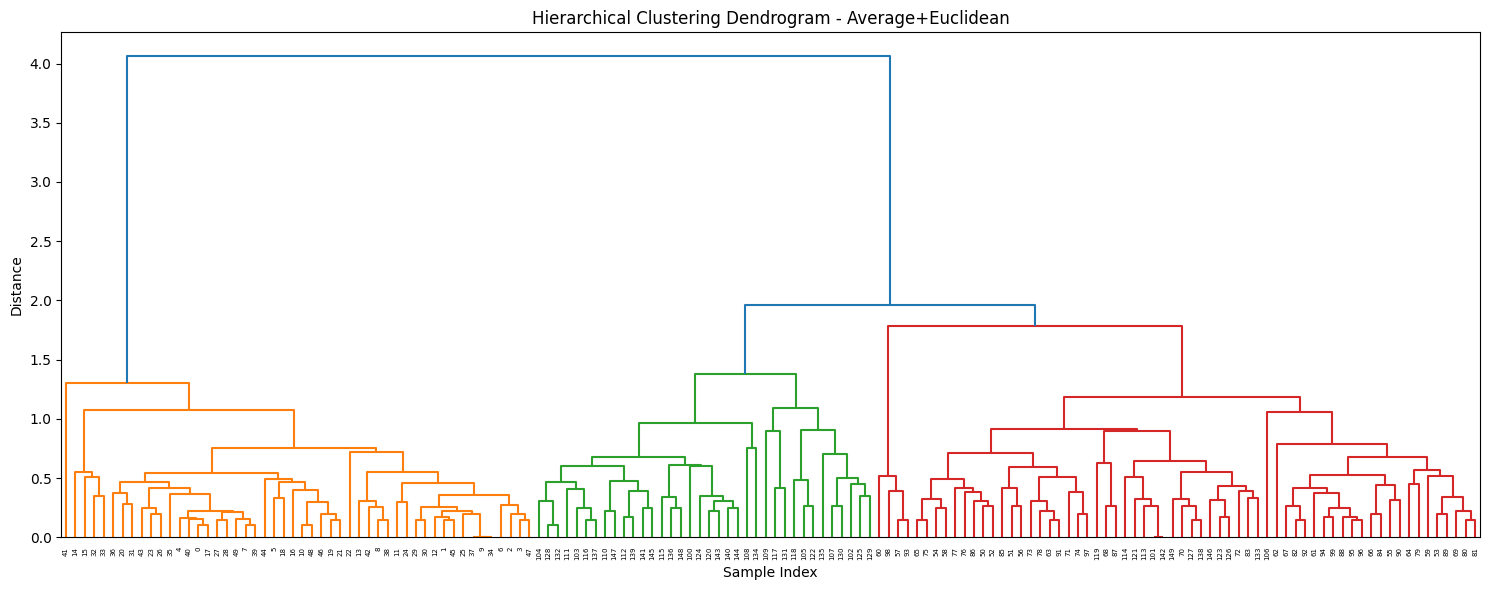

In [16]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
axs = plt.subplots(figsize=(15, 6))
# 绘制树状图
dendrogram(model_average_euclidean.link, ax=axs[1],color_threshold=model_average_euclidean.link[-(model_average_euclidean.n_clusters - 1), 2])
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Distance')
axs[1].set_title('Hierarchical Clustering Dendrogram - Average+Euclidean')

plt.tight_layout()
plt.show()

##### 计算三种方式的准确度

In [17]:
def calculate_accuracy(y_pred, y_true):
    """
    计算分类的准确率
    
    参数：
    y_pred: DataFrame，包含预测的分类结果
    y_true: DataFrame，包含真实的分类结果
    
    返回值：
    accuracy: float，分类的准确率
    """
    # 将索引标签重置为默认的整数索引
    y_pred.reset_index(drop=True, inplace=True)
    y_true.reset_index(drop=True, inplace=True)
    
    # 比较预测结果和真实结果，统计正确分类的数量
    correct = sum(y_pred['Class'] == y_true['class'])
    
    # 计算准确率
    accuracy = correct / len(y_true)
    
    return accuracy

# 计算三种情况的准确率
accuracy_single_euclidean = calculate_accuracy(y_single_euclidean, y)
accuracy_average_euclidean = calculate_accuracy(y_average_euclidean, y)
accuracy_complete_euclidean = calculate_accuracy(y_complete_euclidean, y)

print("Single Linkage + Euclidean Clustering Accuracy:", accuracy_single_euclidean)
print("Complete Linkage + Euclidean Clustering Accuracy:", accuracy_complete_euclidean)
print("Average Linkage + Euclidean Clustering Accuracy:", accuracy_average_euclidean)


Single Linkage + Euclidean Clustering Accuracy: 0.68
Complete Linkage + Euclidean Clustering Accuracy: 0.88
Average Linkage + Euclidean Clustering Accuracy: 1.0


#### 使用Manhattan距离公式进行聚类

##### Single-linkage + Manhattan

In [18]:
model_single_manhattan = HierarchicalClustering(n_clusters=3, linkage='single', distance_method='Manhattan')
cluster_single_manhattan = model_single_manhattan.fit(X_array)
print(cluster_single_manhattan)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149], [106]]


In [19]:
import pandas as pd
# 定义类别标签映射
label_mapping = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
# 创建一个空的 DataFrame
y_single_manhattan = pd.DataFrame(columns=['Class'])
# 遍历 cluster_points，给每个 ID 分配对应的类别
for i, cluster in enumerate(cluster_single_manhattan):
    for id in cluster:
        y_single_manhattan.loc[id] = label_mapping[i]

# 显示结果
print(y_single_manhattan)

               Class
0        Iris-setosa
1        Iris-setosa
2        Iris-setosa
3        Iris-setosa
4        Iris-setosa
..               ...
146  Iris-versicolor
147  Iris-versicolor
148  Iris-versicolor
149  Iris-versicolor
106   Iris-virginica

[150 rows x 1 columns]


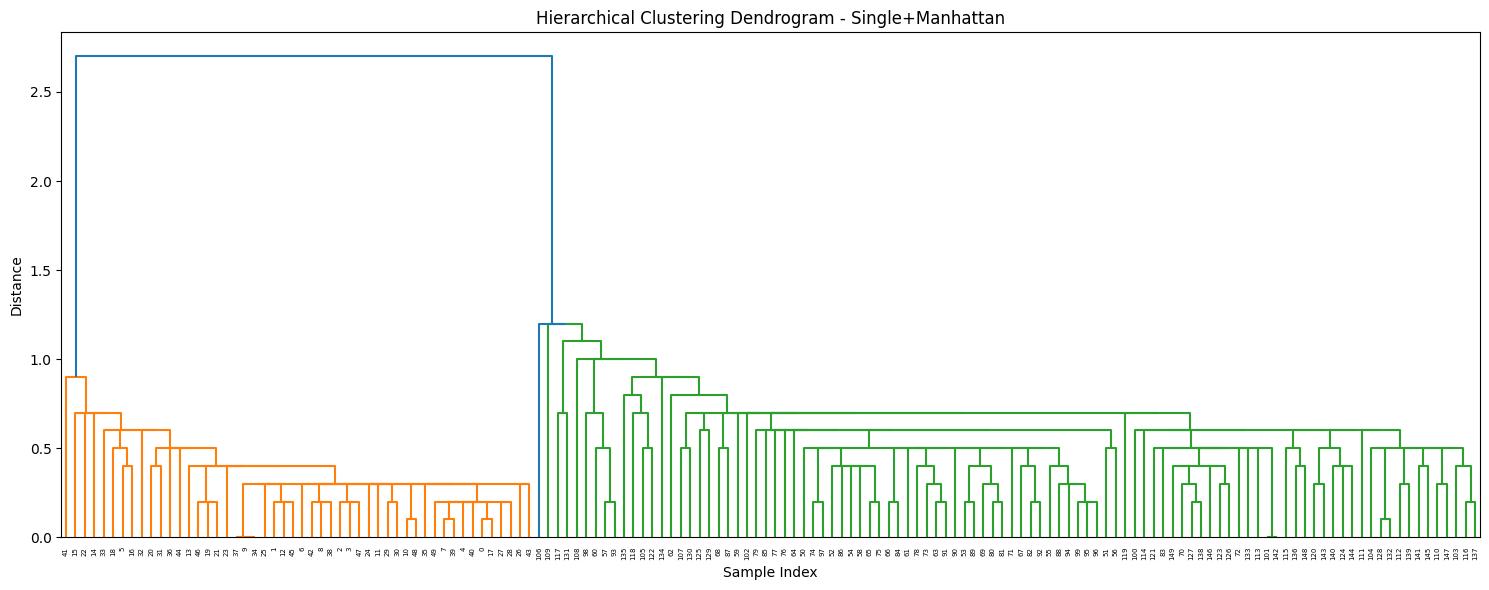

In [20]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
axs = plt.subplots(figsize=(15, 6))
# 绘制树状图
dendrogram(model_single_manhattan.link, ax=axs[1],color_threshold=model_single_manhattan.link[-(model_single_manhattan.n_clusters - 1), 2])
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Distance')
axs[1].set_title('Hierarchical Clustering Dendrogram - Single+Manhattan')

plt.tight_layout()
plt.show()

##### Complete-linkage + Manhattan

In [21]:
model_complete_manhattan = HierarchicalClustering(n_clusters=3, linkage='complete', distance_method='Manhattan')
cluster_complete_manhattan = model_complete_manhattan.fit(X_array)
print(cluster_complete_manhattan)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 54, 56, 58, 63, 65, 70, 73, 74, 75, 76, 77, 78, 85, 86, 91, 97, 100, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 115, 116, 117, 118, 120, 122, 124, 125, 127, 128, 129, 130, 131, 132, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 147, 148, 149], [53, 55, 57, 59, 60, 61, 62, 64, 66, 67, 68, 69, 71, 72, 79, 80, 81, 82, 83, 84, 87, 88, 89, 90, 92, 93, 94, 95, 96, 98, 99, 101, 106, 113, 114, 119, 121, 123, 126, 133, 134, 142, 146]]


In [22]:
import pandas as pd
# 定义类别标签映射
label_mapping = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
# 创建一个空的 DataFrame
y_complete_manhattan = pd.DataFrame(columns=['Class'])
# 遍历 cluster_points，给每个 ID 分配对应的类别
for i, cluster in enumerate(cluster_complete_manhattan):
    for id in cluster:
        y_complete_manhattan.loc[id] = label_mapping[i]

# 显示结果
print(y_complete_manhattan)

              Class
0       Iris-setosa
1       Iris-setosa
2       Iris-setosa
3       Iris-setosa
4       Iris-setosa
..              ...
126  Iris-virginica
133  Iris-virginica
134  Iris-virginica
142  Iris-virginica
146  Iris-virginica

[150 rows x 1 columns]


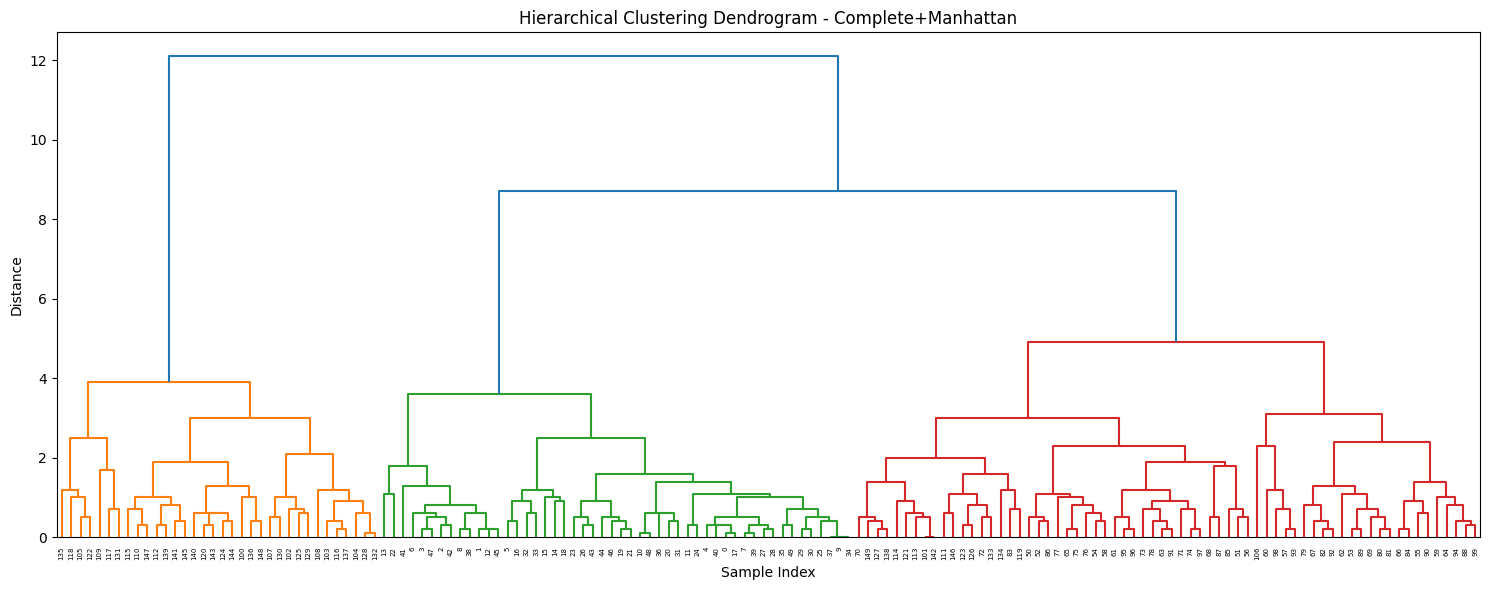

In [23]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
axs = plt.subplots(figsize=(15, 6))
# 绘制树状图
dendrogram(model_complete_manhattan.link, ax=axs[1],color_threshold=model_complete_manhattan.link[-(model_complete_manhattan.n_clusters - 1), 2])
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Distance')
axs[1].set_title('Hierarchical Clustering Dendrogram - Complete+Manhattan')

plt.tight_layout()
plt.show()

##### Average-linkage + Manhattan

In [24]:
model_average_manhattan = HierarchicalClustering(n_clusters=3, linkage='average', distance_method='Manhattan')
cluster_average_manhattan = model_average_manhattan.fit(X_array)
print(cluster_average_manhattan)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 106, 113, 114, 119, 121, 123, 126, 127, 133, 138, 142, 146, 149], [100, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 115, 116, 117, 118, 120, 122, 124, 125, 128, 129, 130, 131, 132, 134, 135, 136, 137, 139, 140, 141, 143, 144, 145, 147, 148]]


In [25]:
import pandas as pd
# 定义类别标签映射
label_mapping = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
# 创建一个空的 DataFrame
y_average_manhattan = pd.DataFrame(columns=['Class'])
# 遍历 cluster_points，给每个 ID 分配对应的类别
for i, cluster in enumerate(cluster_average_manhattan):
    for id in cluster:
        y_average_manhattan.loc[id] = label_mapping[i]

# 显示结果
print(y_average_manhattan)

              Class
0       Iris-setosa
1       Iris-setosa
2       Iris-setosa
3       Iris-setosa
4       Iris-setosa
..              ...
143  Iris-virginica
144  Iris-virginica
145  Iris-virginica
147  Iris-virginica
148  Iris-virginica

[150 rows x 1 columns]


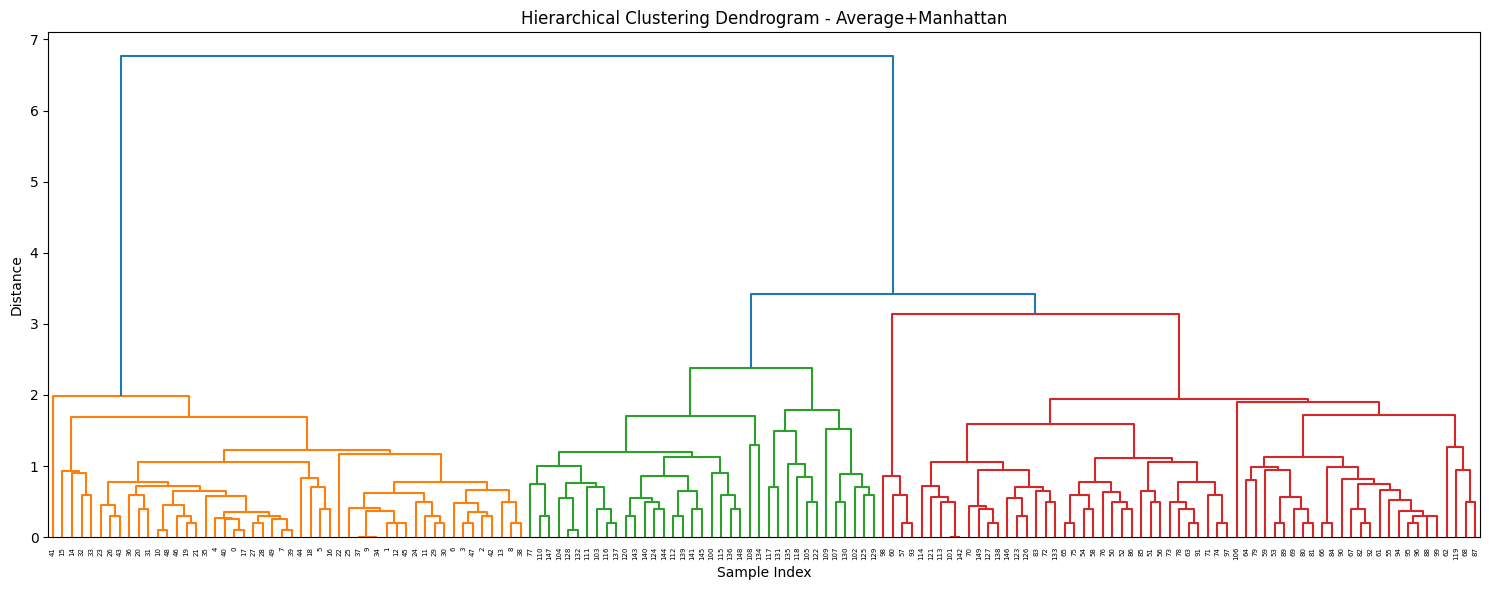

In [26]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
axs = plt.subplots(figsize=(15, 6))
# 绘制树状图
dendrogram(model_average_manhattan.link, ax=axs[1],color_threshold=model_average_manhattan.link[-(model_average_manhattan.n_clusters - 1), 2])
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Distance')
axs[1].set_title('Hierarchical Clustering Dendrogram - Average+Manhattan')

plt.tight_layout()
plt.show()

##### 计算三种方法的准确度

In [27]:
# 计算三种情况的准确率
accuracy_single_manhattan = calculate_accuracy(y_single_manhattan, y)
accuracy_average_manhattan = calculate_accuracy(y_average_manhattan, y)
accuracy_complete_manhattan = calculate_accuracy(y_complete_manhattan, y)

print("Single Linkage + Manhattan Clustering Accuracy:", accuracy_single_manhattan)
print("Complete Linkage + Manhattan Clustering Accuracy:", accuracy_complete_manhattan)
print("Average Linkage + Manhattan Clustering Accuracy:", accuracy_average_manhattan)

Single Linkage + Manhattan Clustering Accuracy: 0.6733333333333333
Complete Linkage + Manhattan Clustering Accuracy: 0.9533333333333334
Average Linkage + Manhattan Clustering Accuracy: 0.9066666666666666


#### 使用Chebyshev距离公式进行聚类

##### Single-linkage + Chebyshev

In [28]:
model_single_chebyshev = HierarchicalClustering(n_clusters=3, linkage='single', distance_method='Chebyshev')
cluster_single_chebyshev = model_single_chebyshev.fit(X_array)
print(cluster_single_chebyshev)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149], [117, 131]]


In [29]:
import pandas as pd
# 定义类别标签映射
label_mapping = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
# 创建一个空的 DataFrame
y_single_chebyshev = pd.DataFrame(columns=['Class'])
# 遍历 cluster_points，给每个 ID 分配对应的类别
for i, cluster in enumerate(cluster_single_chebyshev):
    for id in cluster:
        y_single_chebyshev.loc[id] = label_mapping[i]

# 显示结果
print(y_single_chebyshev)

               Class
0        Iris-setosa
1        Iris-setosa
2        Iris-setosa
3        Iris-setosa
4        Iris-setosa
..               ...
147  Iris-versicolor
148  Iris-versicolor
149  Iris-versicolor
117   Iris-virginica
131   Iris-virginica

[150 rows x 1 columns]


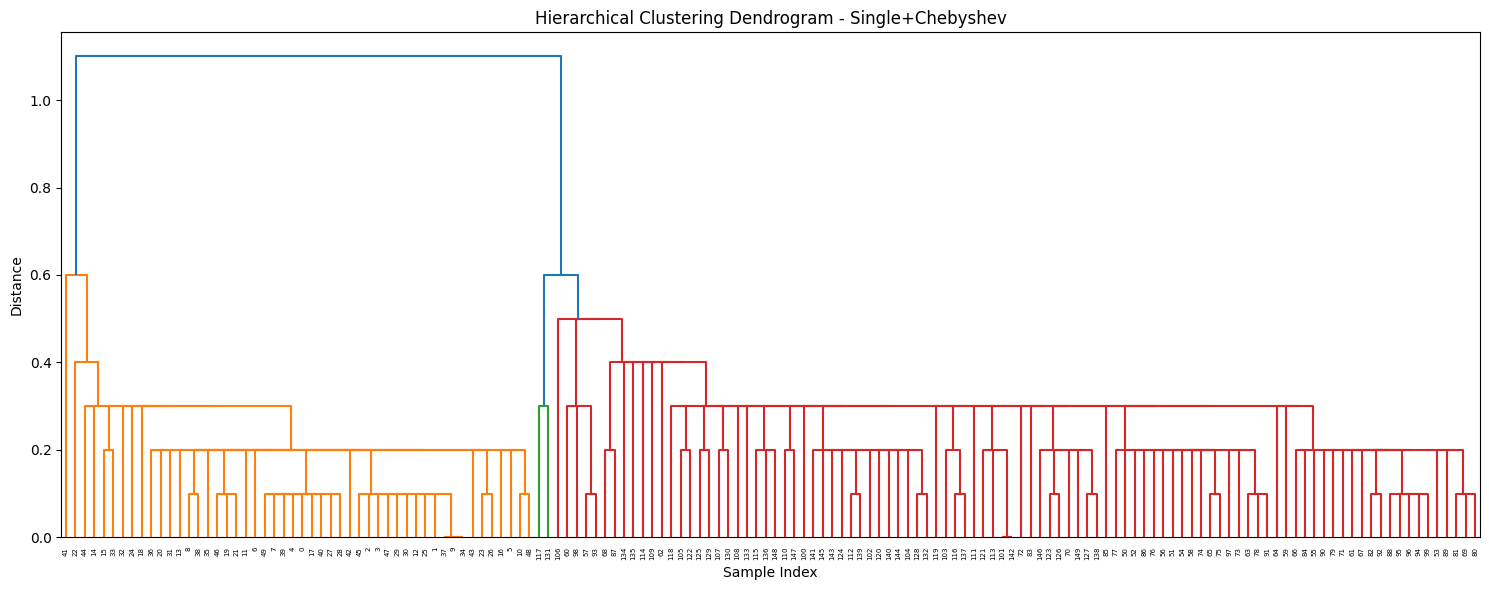

In [30]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
axs = plt.subplots(figsize=(15, 6))
# 绘制树状图
dendrogram(model_single_chebyshev.link, ax=axs[1],color_threshold=model_single_chebyshev.link[-(model_single_chebyshev.n_clusters - 1), 2])
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Distance')
axs[1].set_title('Hierarchical Clustering Dendrogram - Single+Chebyshev')

plt.tight_layout()
plt.show()

##### Complete-linkage + Chebyshev

In [31]:
model_complete_chebyshev = HierarchicalClustering(n_clusters=3, linkage='complete', distance_method='Chebyshev')
cluster_complete_chebyshev = model_complete_chebyshev.fit(X_array)
print(cluster_complete_chebyshev)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 106, 111, 113, 114, 119, 121, 123, 126, 127, 133, 138, 142, 146, 149], [100, 102, 103, 104, 105, 107, 108, 109, 110, 112, 115, 116, 117, 118, 120, 122, 124, 125, 128, 129, 130, 131, 132, 134, 135, 136, 137, 139, 140, 141, 143, 144, 145, 147, 148]]


In [32]:
import pandas as pd
# 定义类别标签映射
label_mapping = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
# 创建一个空的 DataFrame
y_complete_chebyshev = pd.DataFrame(columns=['Class'])
# 遍历 cluster_points，给每个 ID 分配对应的类别
for i, cluster in enumerate(cluster_complete_chebyshev):
    for id in cluster:
        y_complete_chebyshev.loc[id] = label_mapping[i]

# 显示结果
print(y_complete_chebyshev)

              Class
0       Iris-setosa
1       Iris-setosa
2       Iris-setosa
3       Iris-setosa
4       Iris-setosa
..              ...
143  Iris-virginica
144  Iris-virginica
145  Iris-virginica
147  Iris-virginica
148  Iris-virginica

[150 rows x 1 columns]


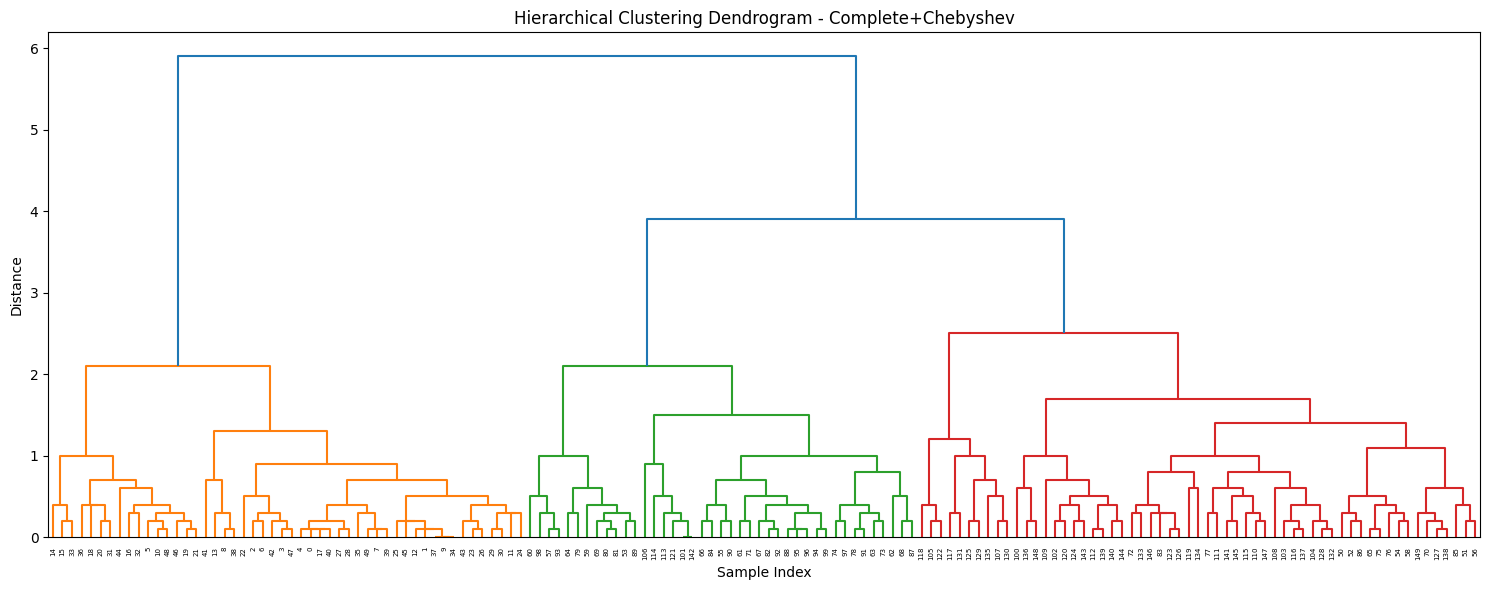

In [33]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
axs = plt.subplots(figsize=(15, 6))
# 绘制树状图
dendrogram(model_complete_chebyshev.link, ax=axs[1],color_threshold=model_complete_chebyshev.link[-(model_complete_chebyshev.n_clusters - 1), 2])
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Distance')
axs[1].set_title('Hierarchical Clustering Dendrogram - Complete+Chebyshev')

plt.tight_layout()
plt.show()

##### Average-linkage + Chebyshev

In [34]:
model_average_chebyshev = HierarchicalClustering(n_clusters=3, linkage='average', distance_method='Chebyshev')
cluster_average_chebyshev = model_average_chebyshev.fit(X_array)
print(cluster_average_chebyshev)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 106, 113, 119, 121, 123, 126, 127, 133, 138, 142, 146, 149], [100, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 120, 122, 124, 125, 128, 129, 130, 131, 132, 134, 135, 136, 137, 139, 140, 141, 143, 144, 145, 147, 148]]


In [35]:
import pandas as pd
# 定义类别标签映射
label_mapping = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
# 创建一个空的 DataFrame
y_average_chebyshev = pd.DataFrame(columns=['Class'])
# 遍历 cluster_points，给每个 ID 分配对应的类别
for i, cluster in enumerate(cluster_average_chebyshev):
    for id in cluster:
        y_average_chebyshev.loc[id] = label_mapping[i]

# 显示结果
print(y_average_chebyshev)

              Class
0       Iris-setosa
1       Iris-setosa
2       Iris-setosa
3       Iris-setosa
4       Iris-setosa
..              ...
143  Iris-virginica
144  Iris-virginica
145  Iris-virginica
147  Iris-virginica
148  Iris-virginica

[150 rows x 1 columns]


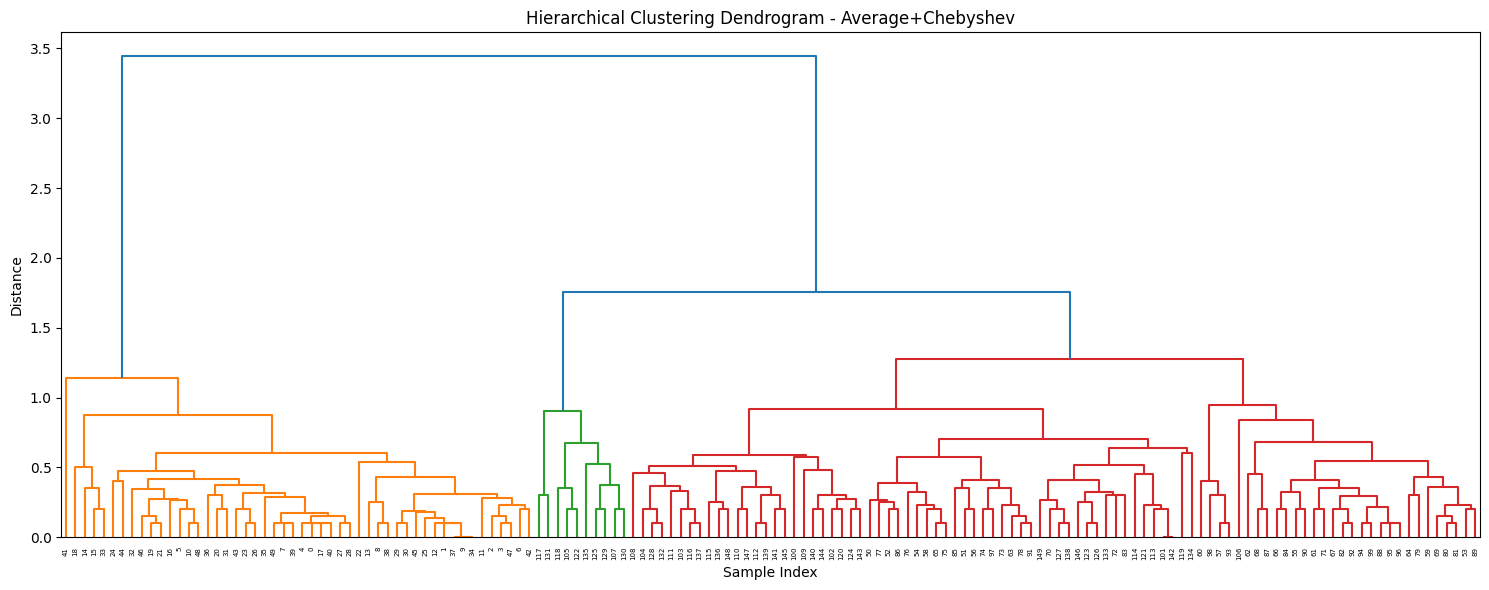

In [36]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
axs = plt.subplots(figsize=(15, 6))
# 绘制树状图
dendrogram(model_average_chebyshev.link, ax=axs[1],color_threshold=model_average_chebyshev.link[-(model_average_chebyshev.n_clusters - 1), 2])
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Distance')
axs[1].set_title('Hierarchical Clustering Dendrogram - Average+Chebyshev')

plt.tight_layout()
plt.show()

##### 计算三种方法的准确度

In [37]:
# 计算三种情况的准确率
accuracy_single_chebyshev = calculate_accuracy(y_single_chebyshev, y)
accuracy_average_chebyshev = calculate_accuracy(y_average_chebyshev, y)
accuracy_complete_chebyshev = calculate_accuracy(y_complete_chebyshev, y)

print("Single Linkage + Chebyshev Clustering Accuracy:", accuracy_single_chebyshev)
print("Complete Linkage + Chebyshev Clustering Accuracy:", accuracy_complete_chebyshev)
print("Average Linkage + Chebyshev Clustering Accuracy:", accuracy_average_chebyshev)

Single Linkage + Chebyshev Clustering Accuracy: 0.68
Complete Linkage + Chebyshev Clustering Accuracy: 0.9
Average Linkage + Chebyshev Clustering Accuracy: 0.9133333333333333


#### 总结

In [38]:
import pandas as pd

# 创建一个空的 DataFrame
data = {
    'Model': ['Single Euclidean', 'Single Manhattan', 'Single Chebyshev',
              'Complete Euclidean', 'Complete Manhattan', 'Complete Chebyshev',
              'Average Euclidean', 'Average Manhattan', 'Average Chebyshev'],
    'Time (seconds)': [model_single_euclidean.time, model_single_manhattan.time, model_single_chebyshev.time,
                       model_complete_euclidean.time, model_complete_manhattan.time, model_complete_chebyshev.time,
                       model_average_euclidean.time, model_average_manhattan.time, model_average_chebyshev.time],
    'Accuracy': [accuracy_single_euclidean, accuracy_single_manhattan, accuracy_single_chebyshev,
                 accuracy_complete_euclidean, accuracy_complete_manhattan, accuracy_complete_chebyshev,
                 accuracy_average_euclidean, accuracy_average_manhattan, accuracy_average_chebyshev]
}

df = pd.DataFrame(data)
df_sort = df.sort_values(by='Accuracy', ascending=False)
# 打印 DataFrame
print(df_sort)

                Model  Time (seconds)  Accuracy
6   Average Euclidean        0.357053  1.000000
4  Complete Manhattan        0.391142  0.953333
8   Average Chebyshev        0.433251  0.913333
7   Average Manhattan        0.395126  0.906667
5  Complete Chebyshev        0.455184  0.900000
3  Complete Euclidean        0.350054  0.880000
0    Single Euclidean        0.351405  0.680000
2    Single Chebyshev        0.439568  0.680000
1    Single Manhattan        0.387728  0.673333


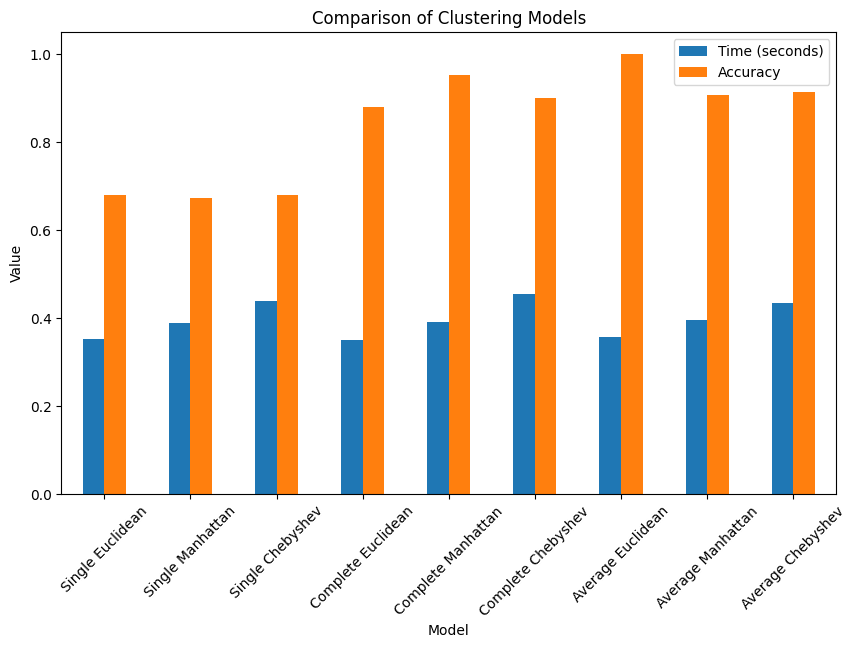

In [39]:
import matplotlib.pyplot as plt

# 创建柱状图
ax = df.plot(kind='bar', figsize=(10, 6))

# 设置图表标题和标签
plt.title('Comparison of Clustering Models')
plt.xlabel('Model')
plt.ylabel('Value')

# 设置横轴标签
ax.set_xticklabels(df.Model, rotation=45)

# 显示图例
plt.legend()

# 显示柱状图
plt.show()

### 对二维数据进行聚类分析

/var/folders/jf/x4pf2z053hlfy6br61djl51c0000gn/T/ipykernel_55573/1353193228.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame(data=[[features, strategy, metric, accuracy, model.time]],


single-Euclidean
sepal length
sepal width


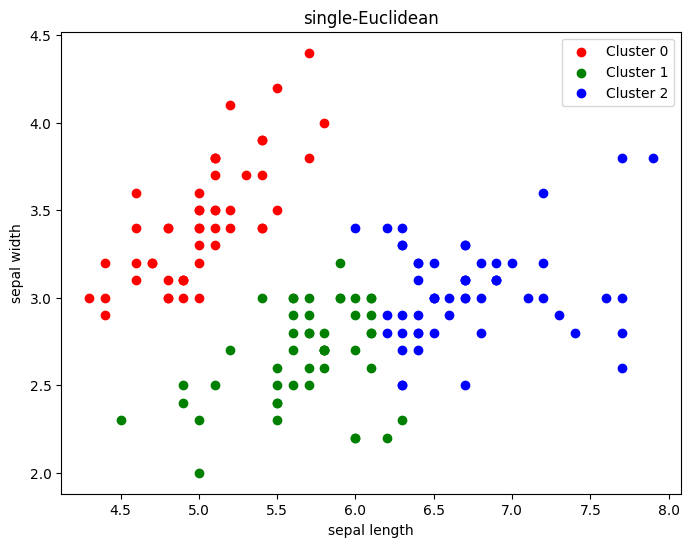

single-Manhattan
sepal length
sepal width


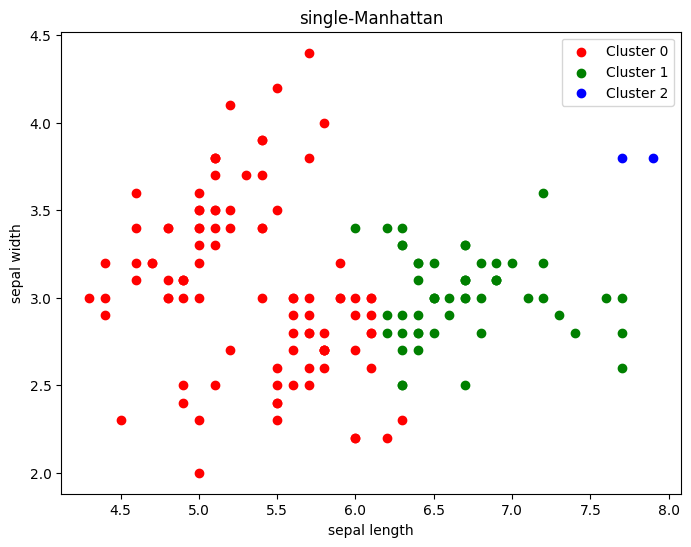

single-Chebyshev
sepal length
sepal width


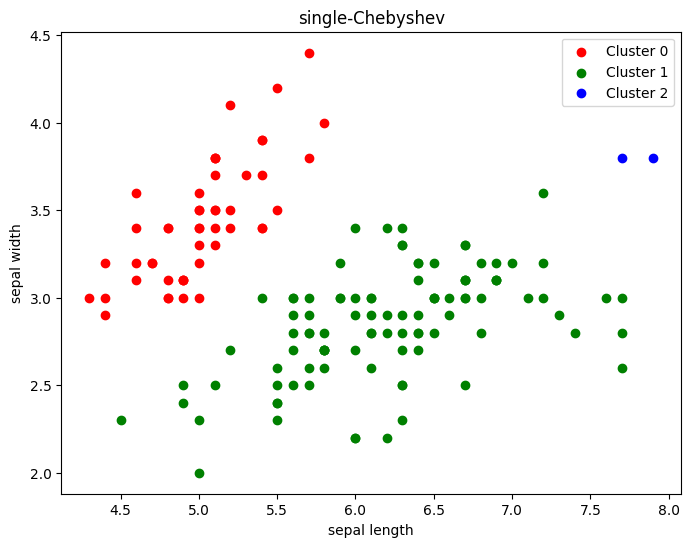

complete-Euclidean
sepal length
sepal width


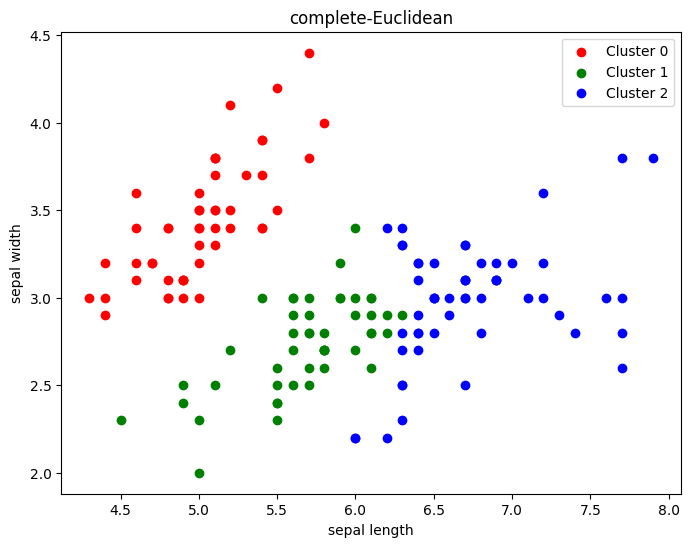

complete-Manhattan
sepal length
sepal width


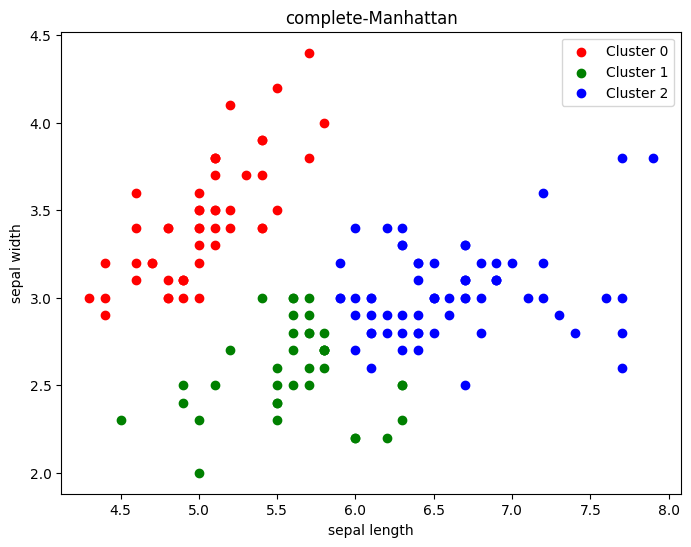

complete-Chebyshev
sepal length
sepal width


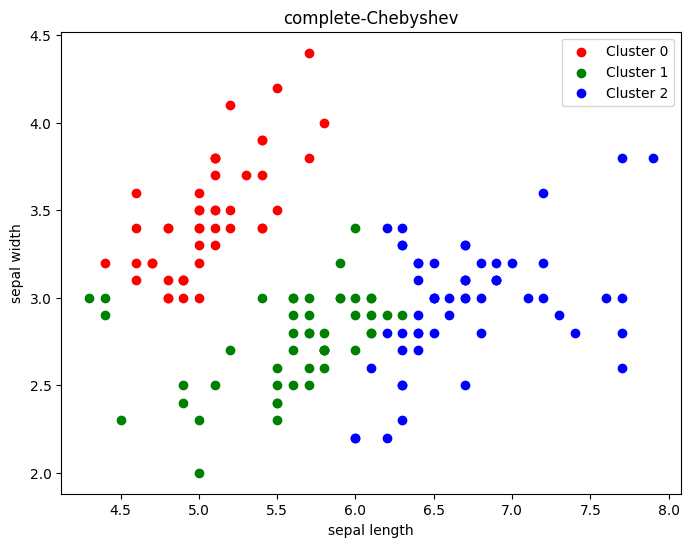

average-Euclidean
sepal length
sepal width


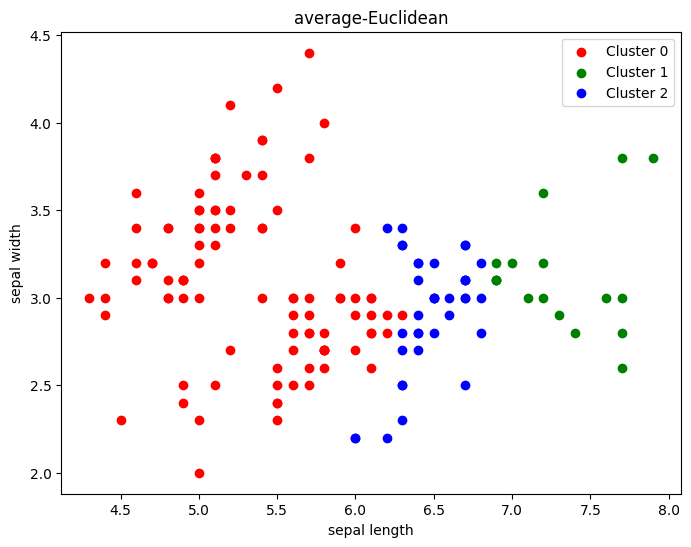

average-Manhattan
sepal length
sepal width


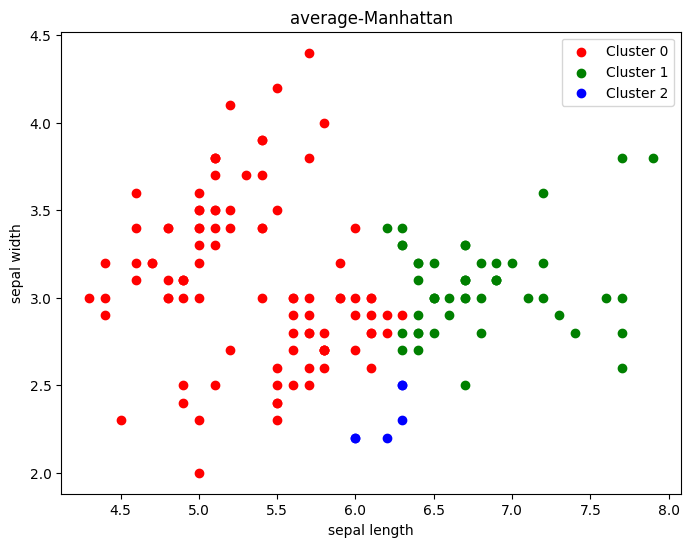

average-Chebyshev
sepal length
sepal width


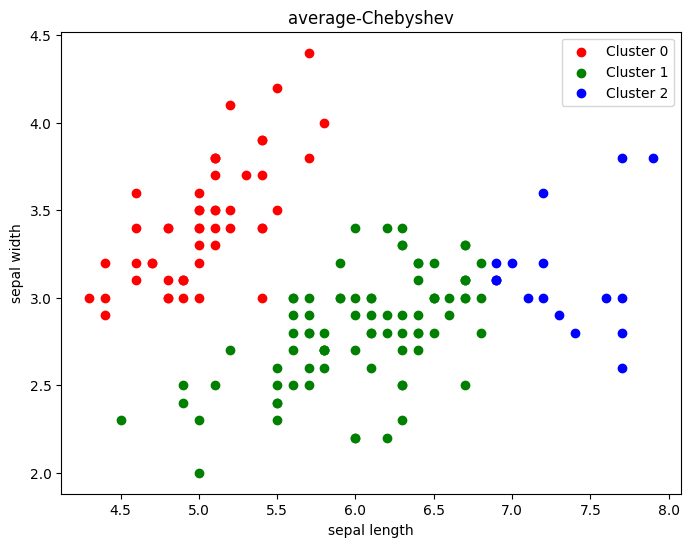

single-Euclidean
sepal length
petal length


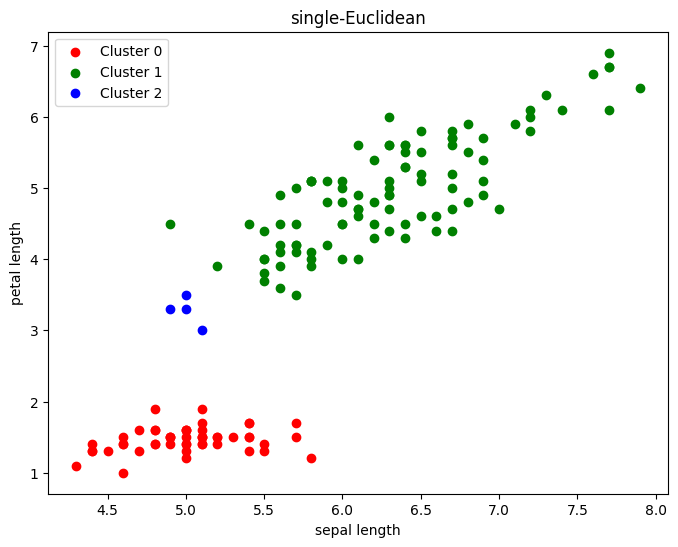

single-Manhattan
sepal length
petal length


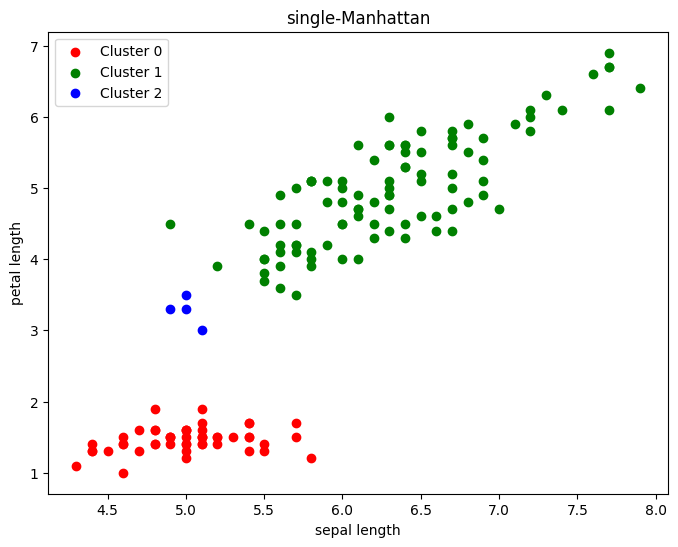

single-Chebyshev
sepal length
petal length


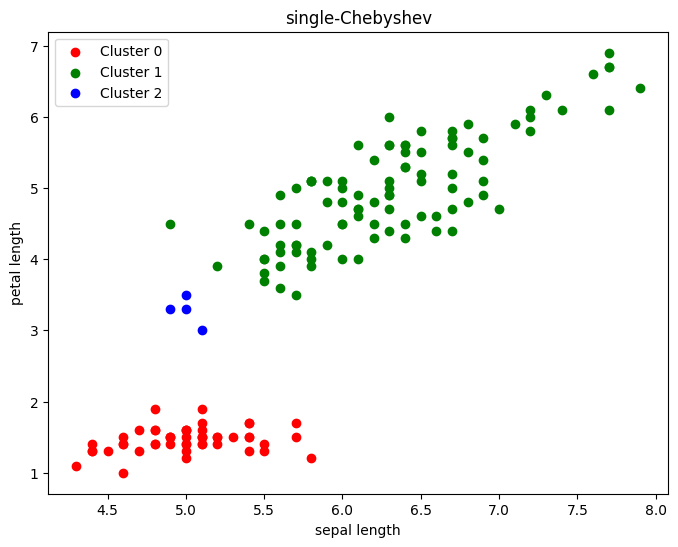

complete-Euclidean
sepal length
petal length


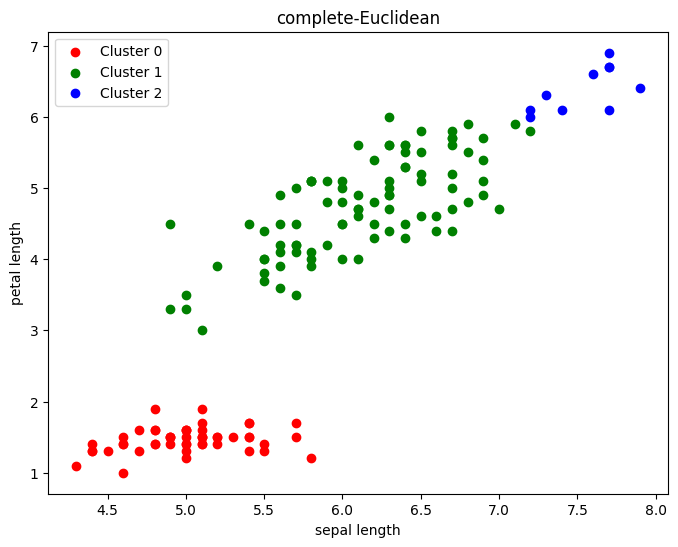

complete-Manhattan
sepal length
petal length


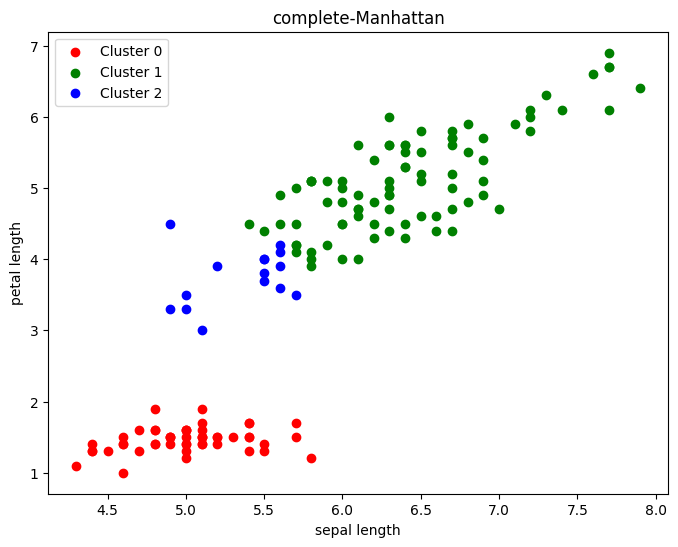

complete-Chebyshev
sepal length
petal length


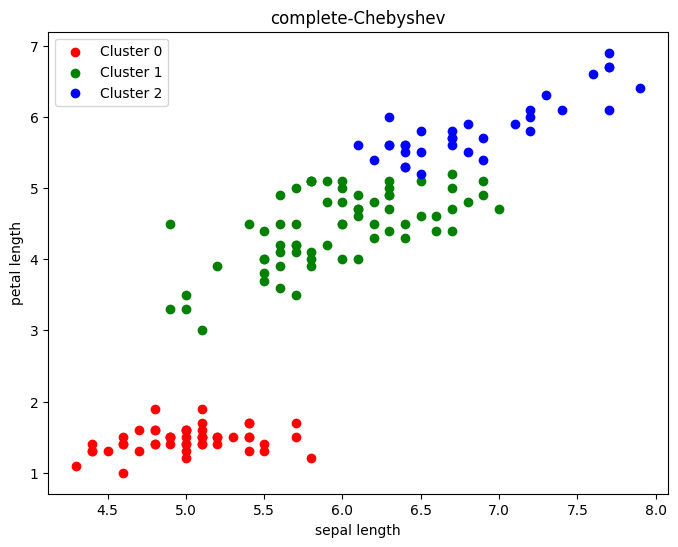

average-Euclidean
sepal length
petal length


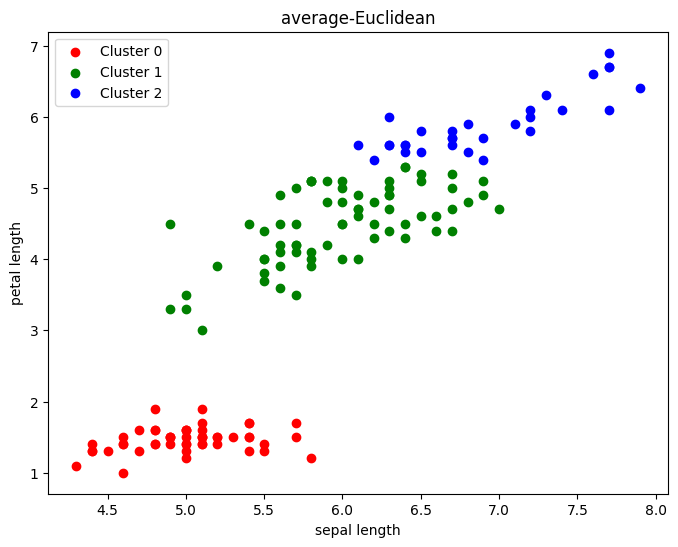

average-Manhattan
sepal length
petal length


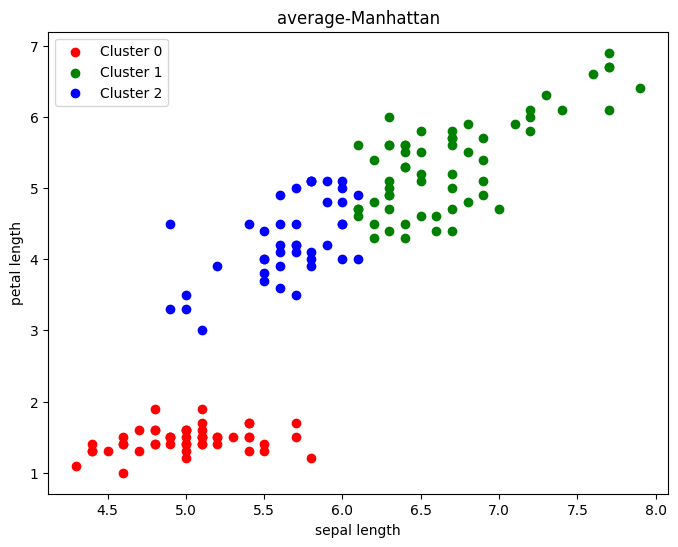

average-Chebyshev
sepal length
petal length


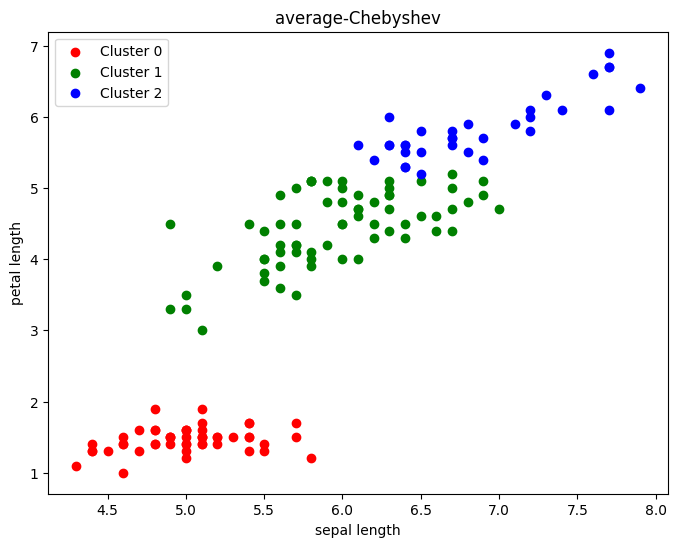

single-Euclidean
sepal length
petal width


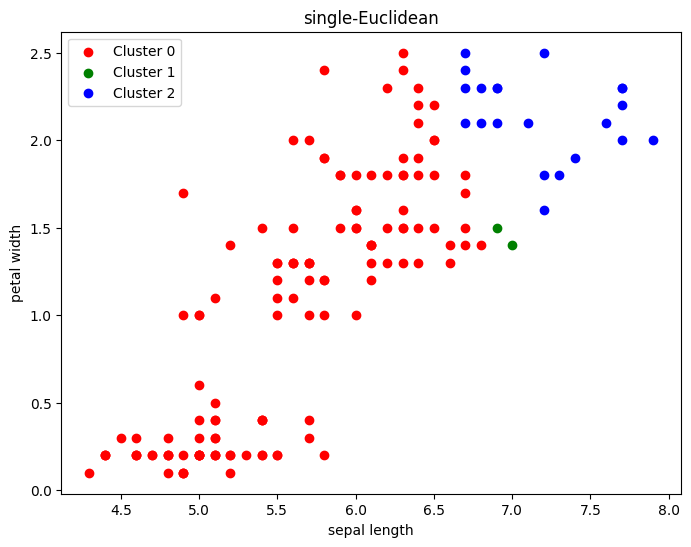

single-Manhattan
sepal length
petal width


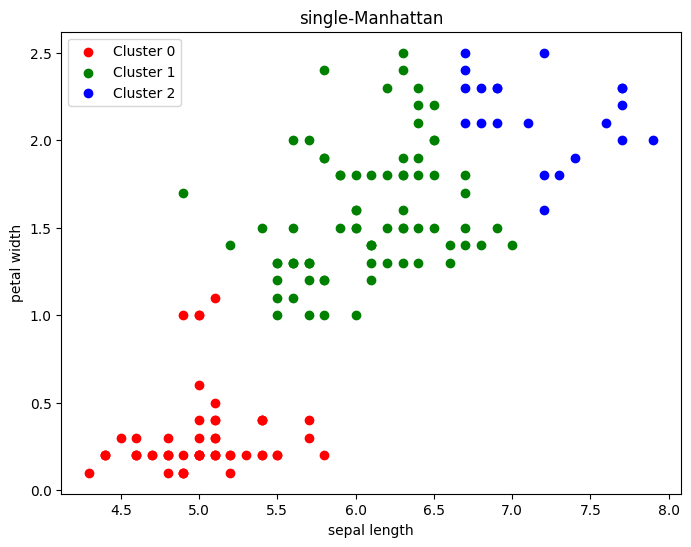

single-Chebyshev
sepal length
petal width


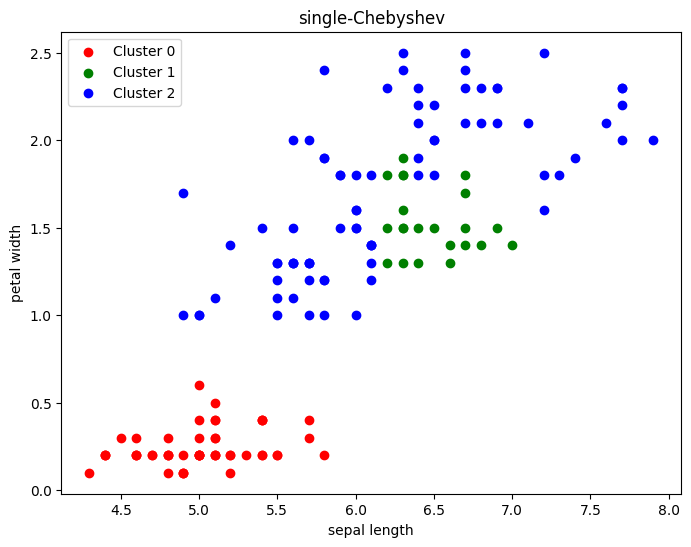

complete-Euclidean
sepal length
petal width


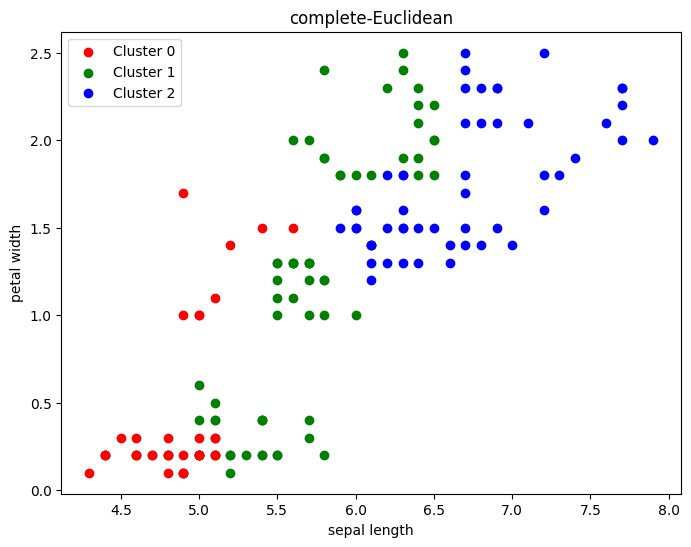

complete-Manhattan
sepal length
petal width


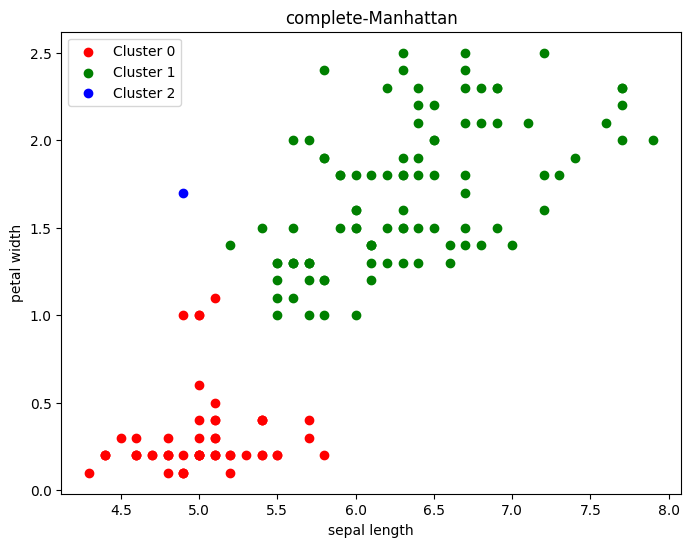

complete-Chebyshev
sepal length
petal width


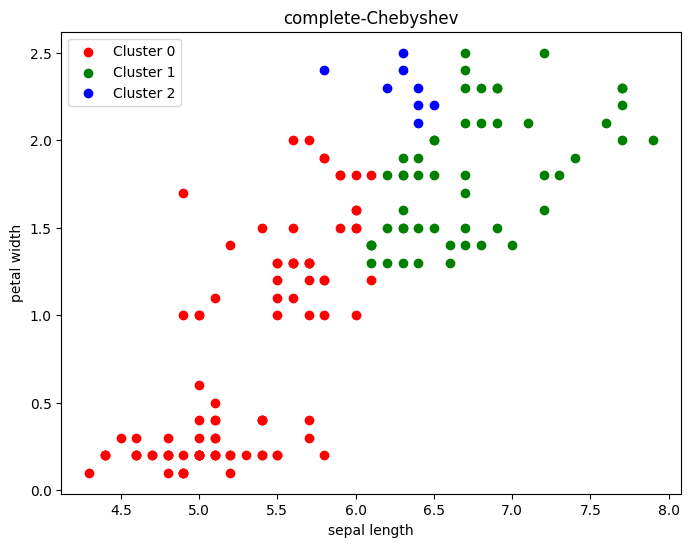

average-Euclidean
sepal length
petal width


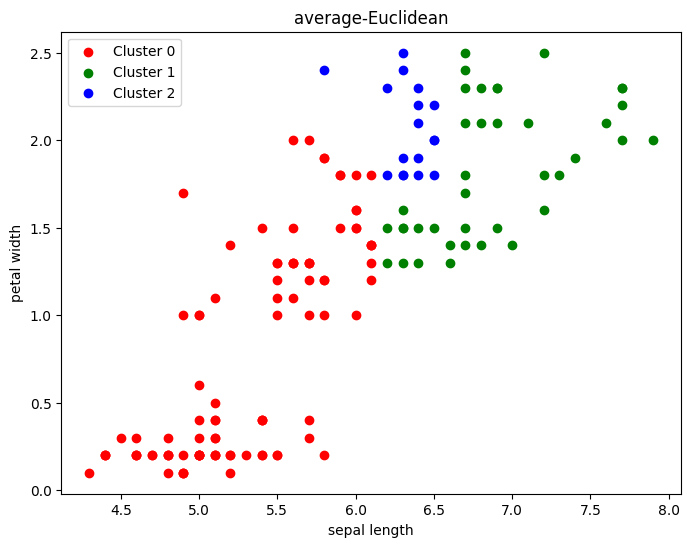

average-Manhattan
sepal length
petal width


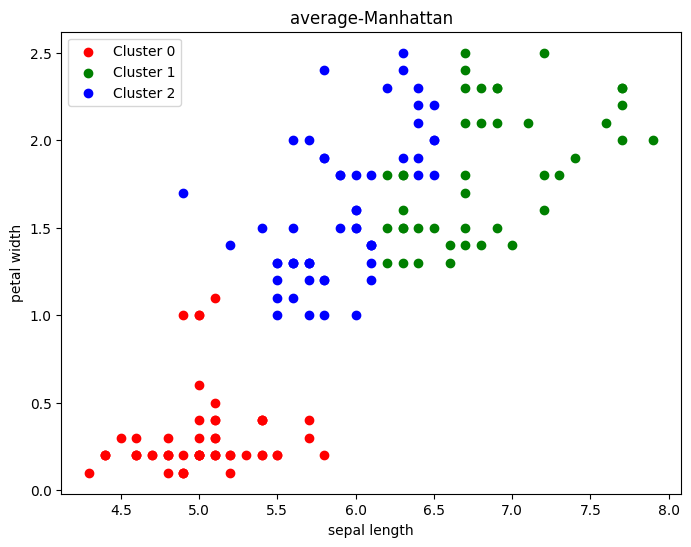

average-Chebyshev
sepal length
petal width


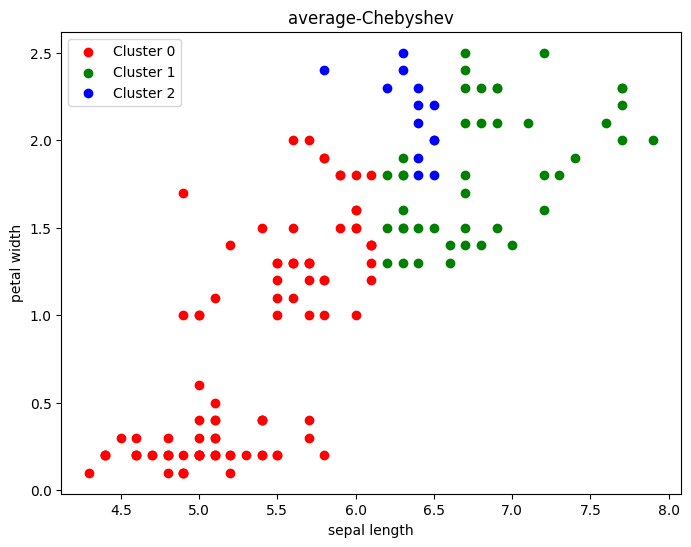

single-Euclidean
sepal width
petal length


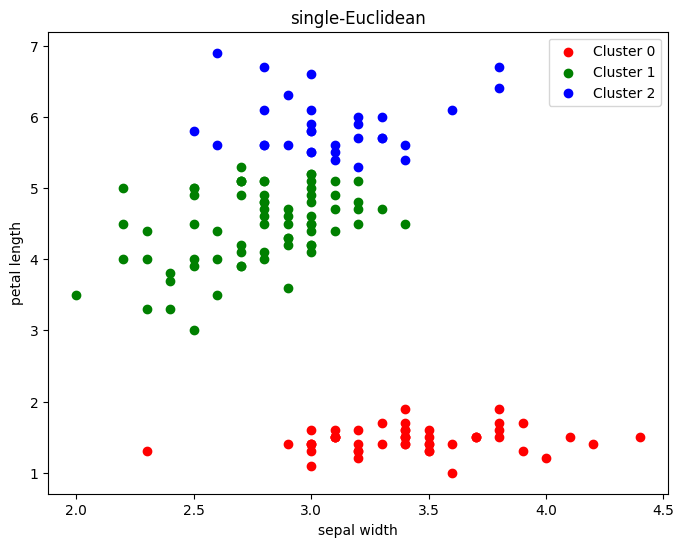

single-Manhattan
sepal width
petal length


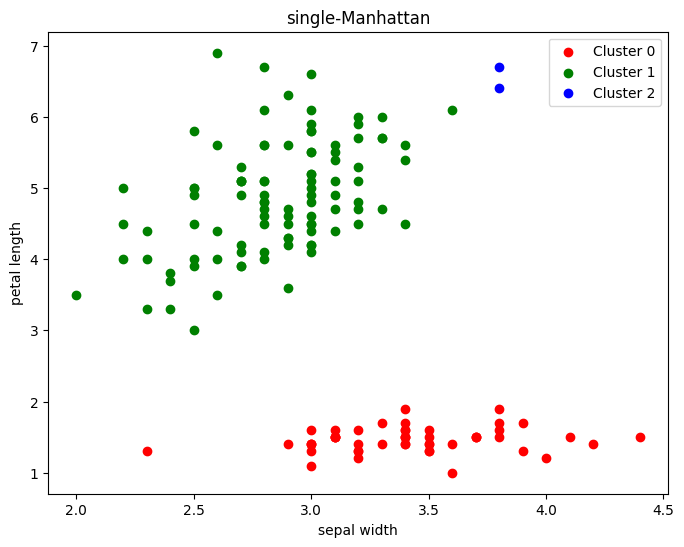

single-Chebyshev
sepal width
petal length


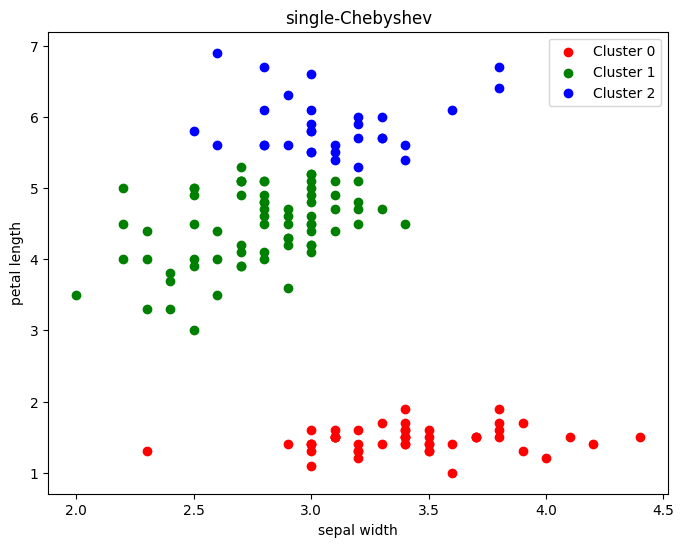

complete-Euclidean
sepal width
petal length


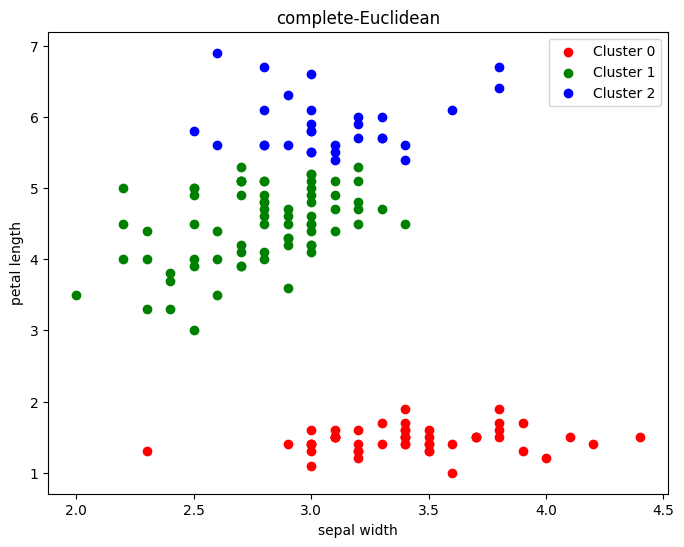

complete-Manhattan
sepal width
petal length


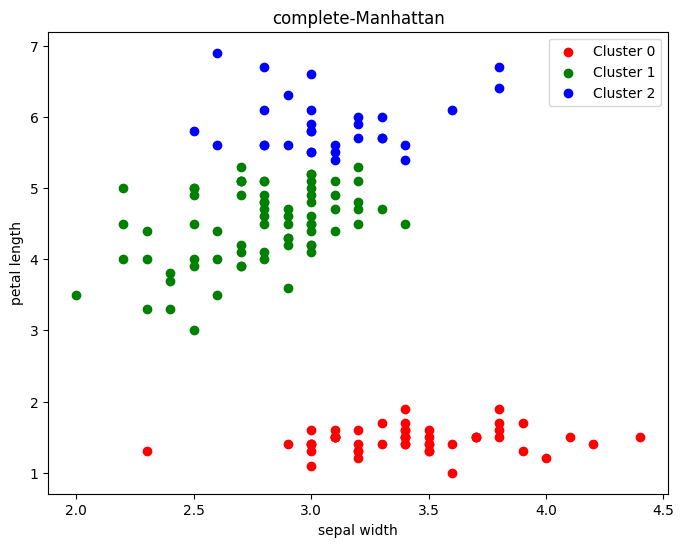

complete-Chebyshev
sepal width
petal length


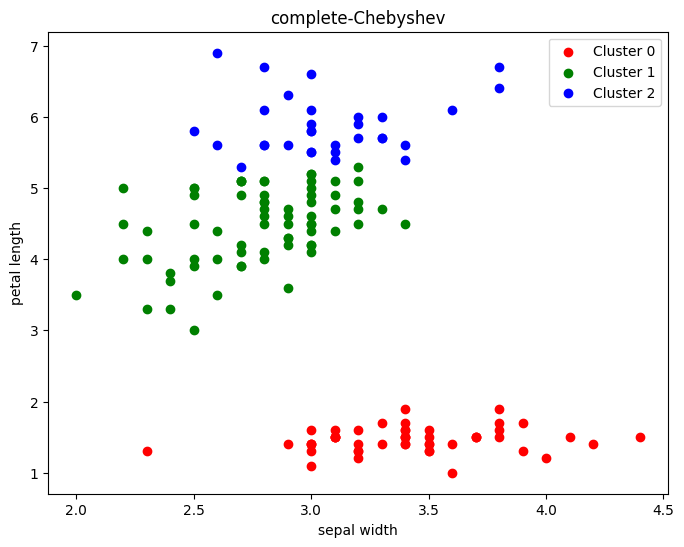

average-Euclidean
sepal width
petal length


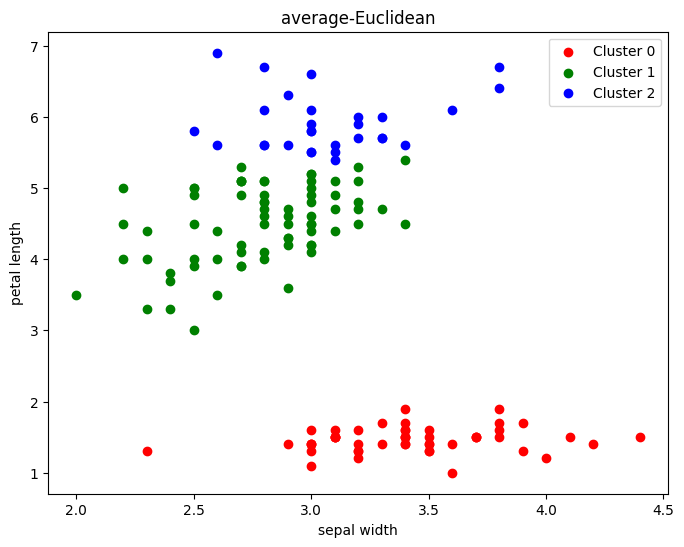

average-Manhattan
sepal width
petal length


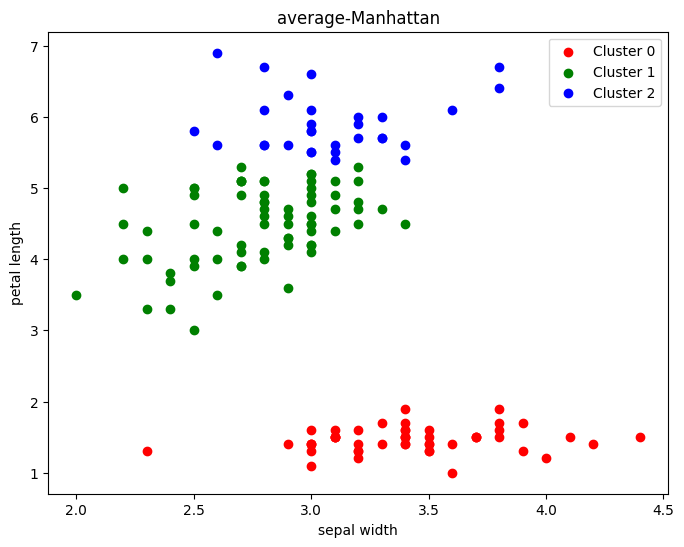

average-Chebyshev
sepal width
petal length


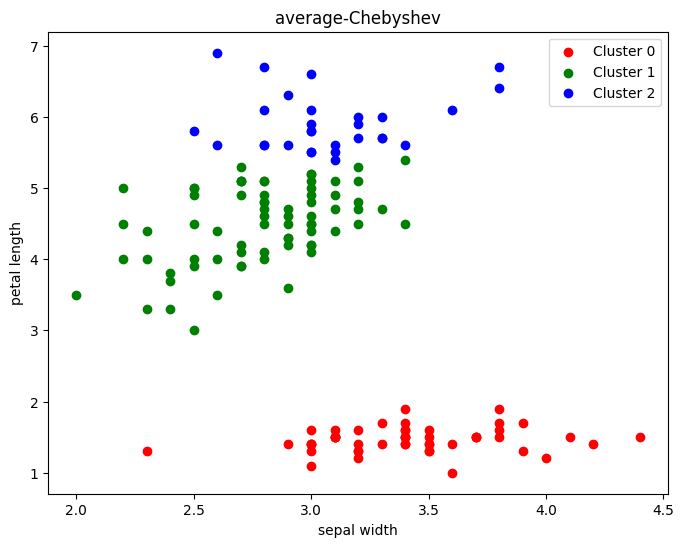

single-Euclidean
sepal width
petal width


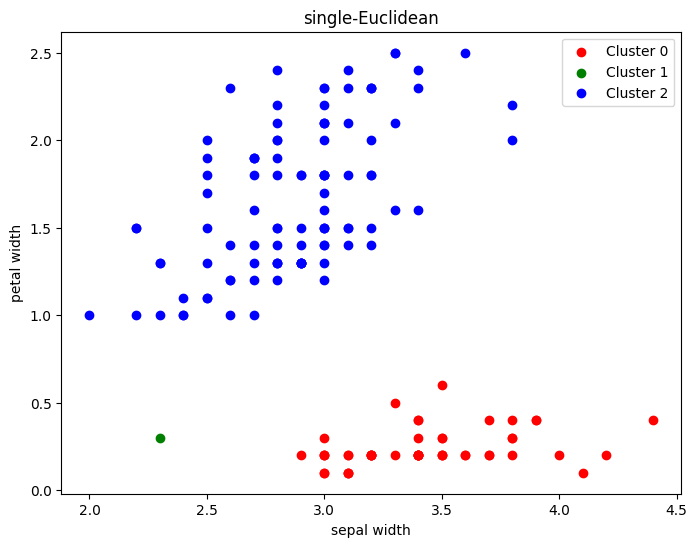

single-Manhattan
sepal width
petal width


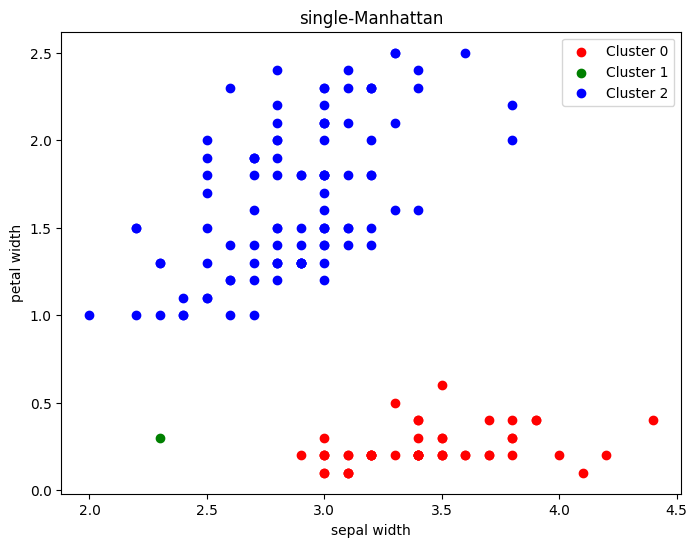

single-Chebyshev
sepal width
petal width


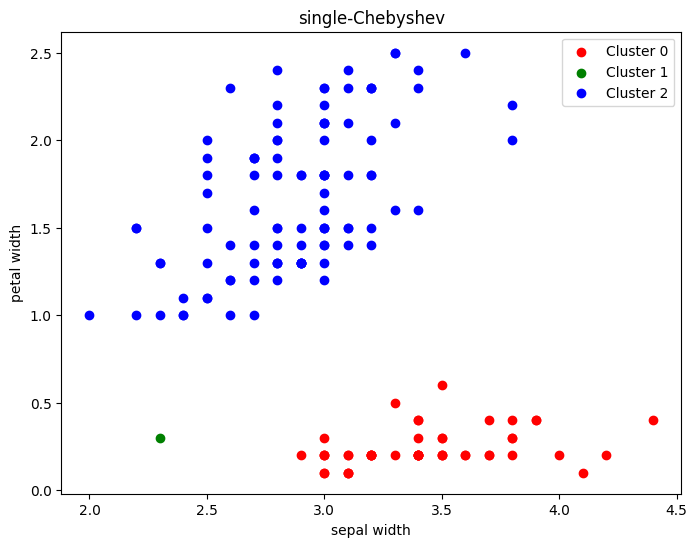

complete-Euclidean
sepal width
petal width


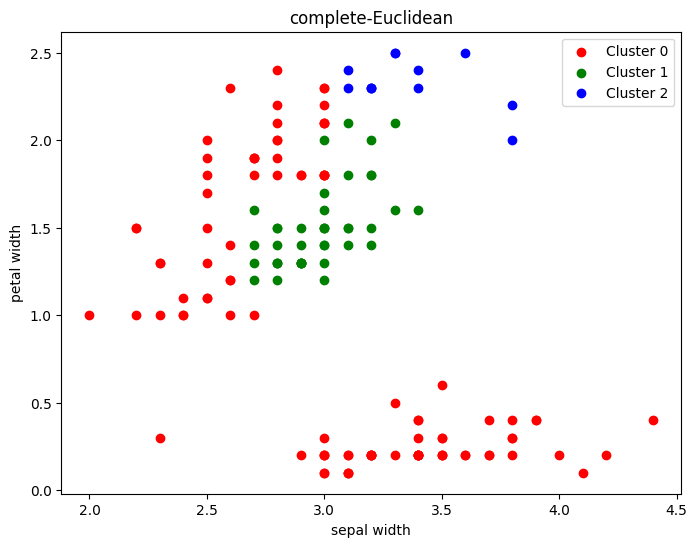

complete-Manhattan
sepal width
petal width


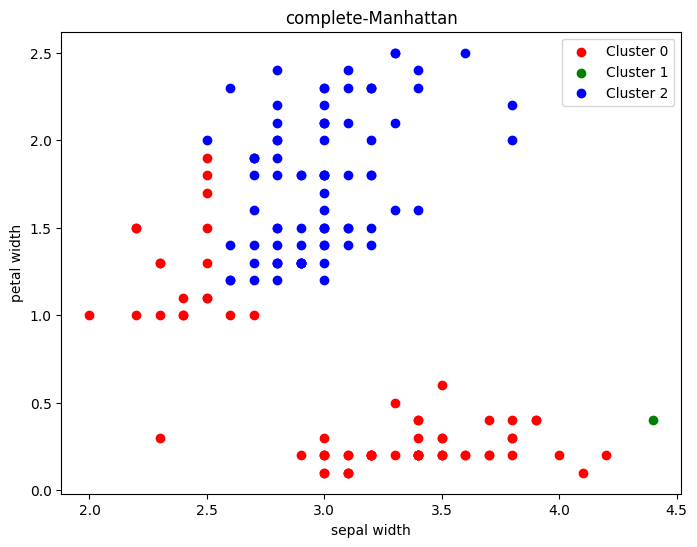

complete-Chebyshev
sepal width
petal width


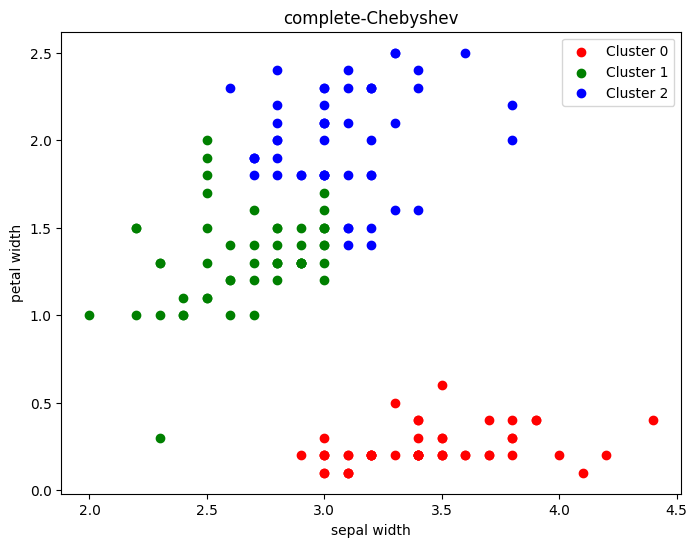

average-Euclidean
sepal width
petal width


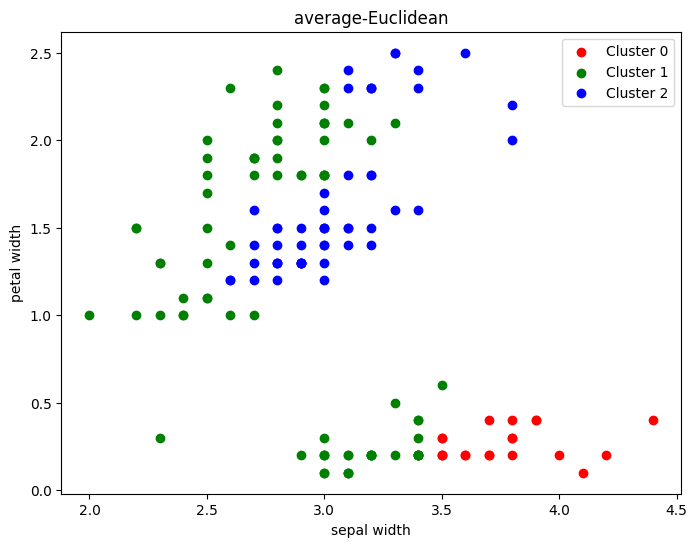

average-Manhattan
sepal width
petal width


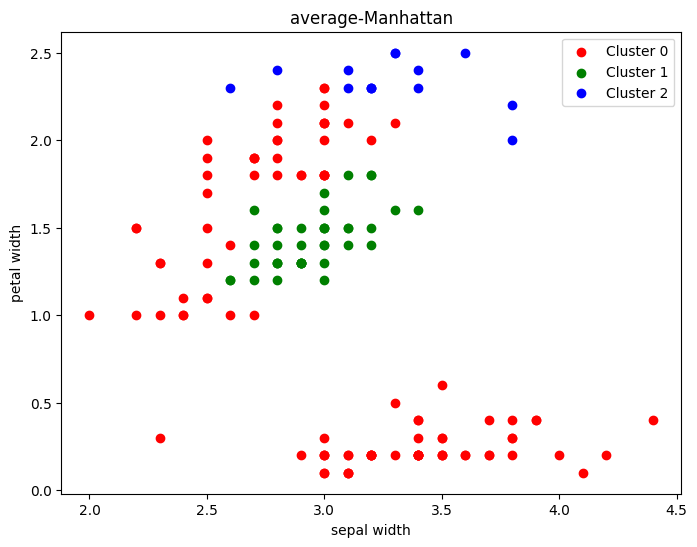

average-Chebyshev
sepal width
petal width


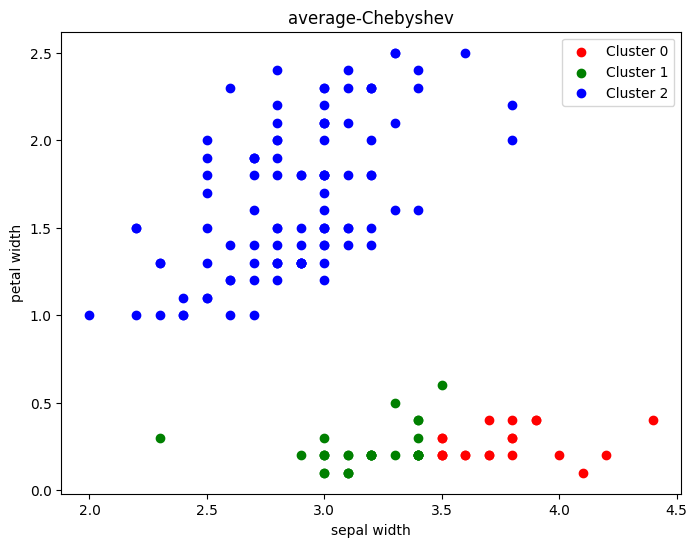

single-Euclidean
petal length
petal width


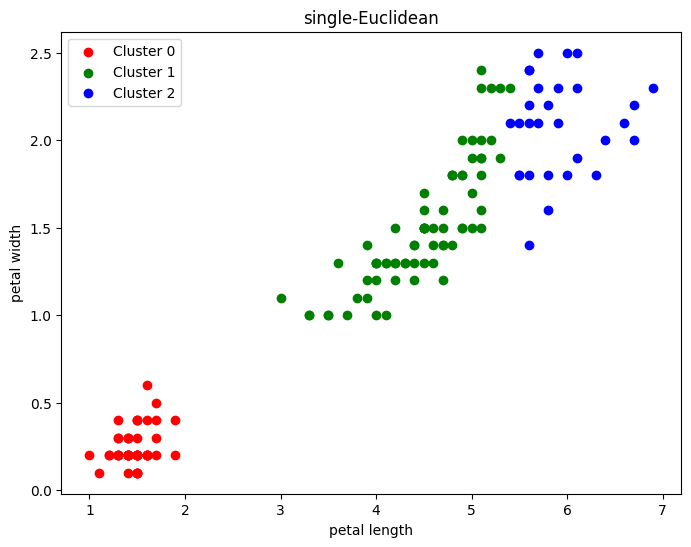

single-Manhattan
petal length
petal width


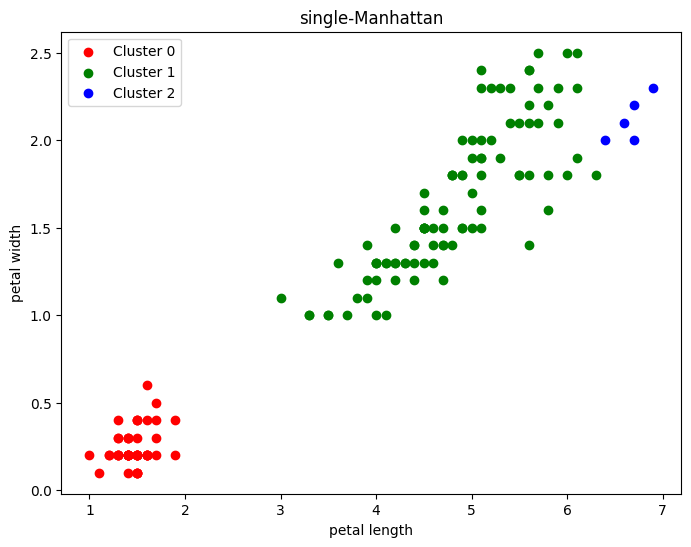

single-Chebyshev
petal length
petal width


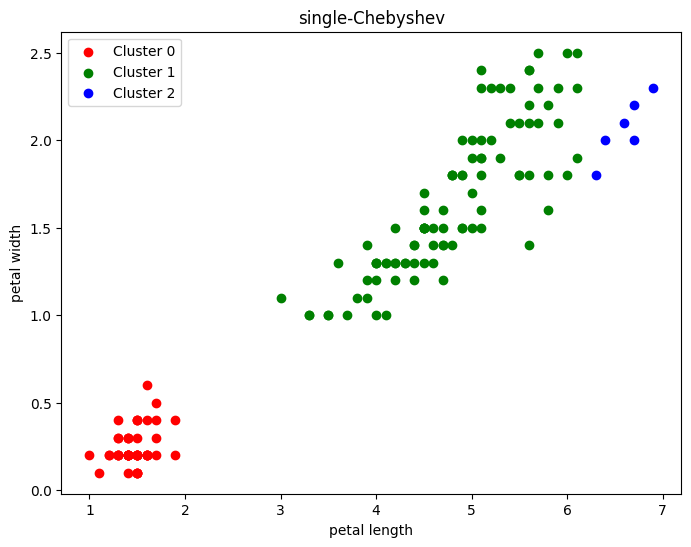

complete-Euclidean
petal length
petal width


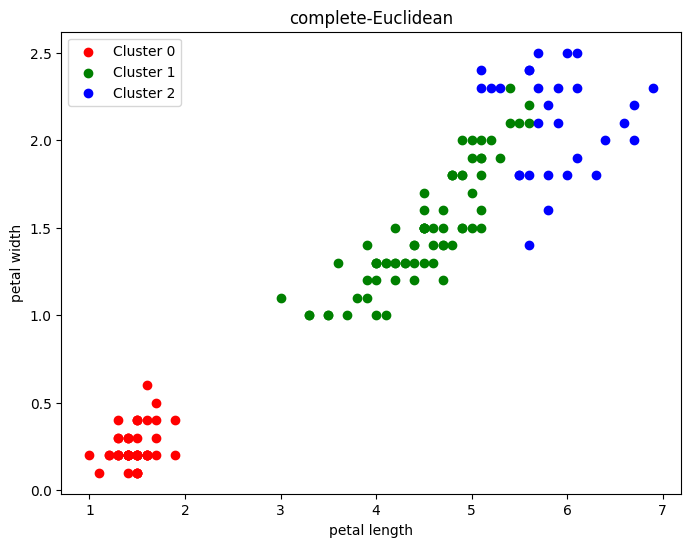

complete-Manhattan
petal length
petal width


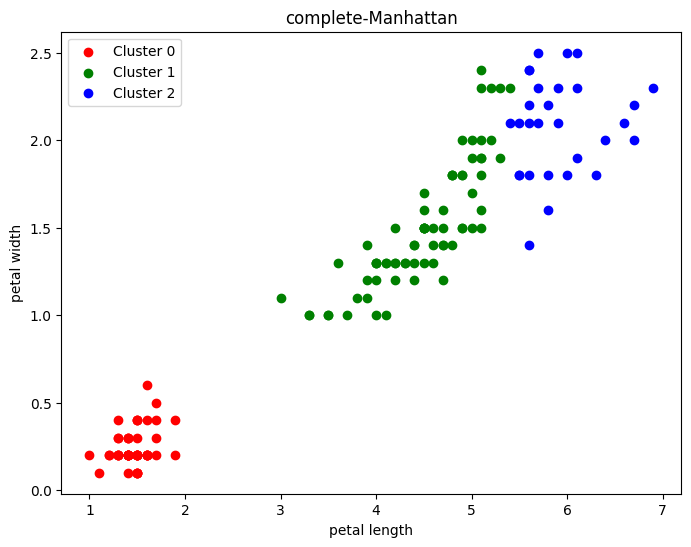

complete-Chebyshev
petal length
petal width


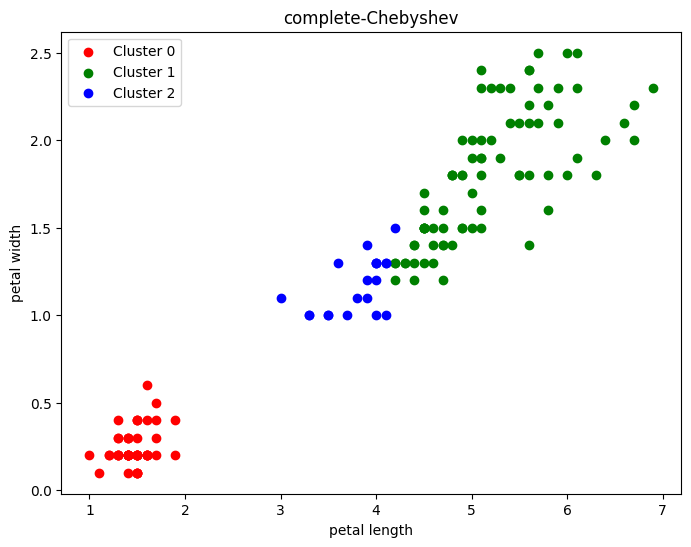

average-Euclidean
petal length
petal width


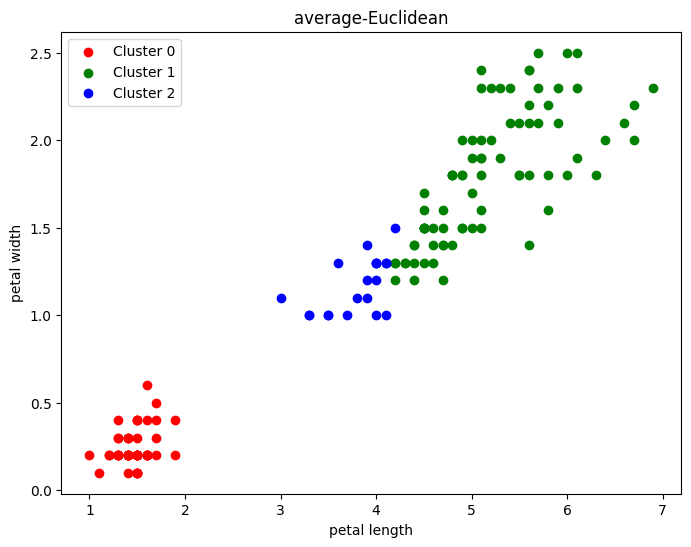

average-Manhattan
petal length
petal width


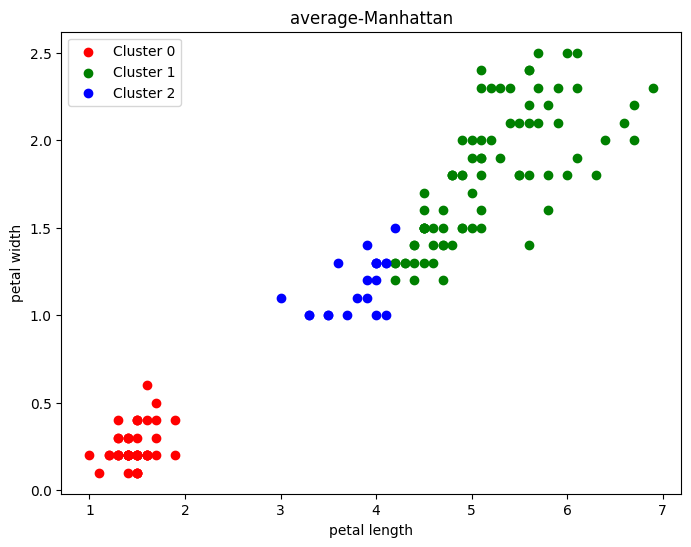

average-Chebyshev
petal length
petal width


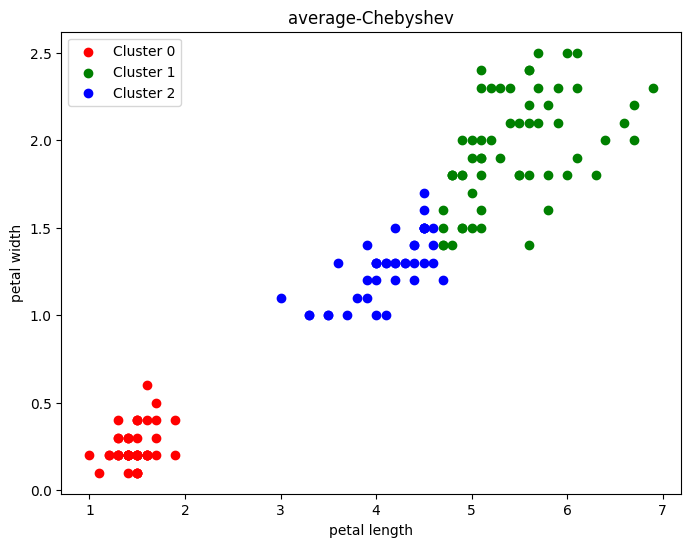

                        Features Clustering Strategy Distance Metric  \
0    [sepal length, sepal width]              single       Euclidean   
1    [sepal length, sepal width]              single       Manhattan   
2    [sepal length, sepal width]              single       Chebyshev   
3    [sepal length, sepal width]            complete       Euclidean   
4    [sepal length, sepal width]            complete       Manhattan   
5    [sepal length, sepal width]            complete       Chebyshev   
6    [sepal length, sepal width]             average       Euclidean   
7    [sepal length, sepal width]             average       Manhattan   
8    [sepal length, sepal width]             average       Chebyshev   
9   [sepal length, petal length]              single       Euclidean   
10  [sepal length, petal length]              single       Manhattan   
11  [sepal length, petal length]              single       Chebyshev   
12  [sepal length, petal length]            complete       Eucli

In [56]:
import pandas as pd
from sklearn.metrics import accuracy_score

# 假设您已经加载了鸢尾花数据集并存储在 iris_df 中，包含特征和真实标签 y
# 假设 iris_df 包含特征 ['sepal length', 'sepal width', 'petal length', 'petal width'] 和标签 'class'

iris_df = X
# print(iris_df)
# 创建一个 DataFrame 用于存储结果
results_df = pd.DataFrame(columns=['Features', 'Clustering Strategy', 'Distance Metric', 'Accuracy', 'Time'])
# 定义聚类策略和距离度量
strategies = ['single', 'complete', 'average']
metrics = ['Euclidean', 'Manhattan', 'Chebyshev']
label_mapping = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
features_select = ["sepal length", "sepal width", "petal length", "petal width"]

# 对每一对特征组合进行循环
for i in range(len(features_select)):
    # print(i)
    for j in range(i + 1, len(features_select)):

        # 选择当前的两个特征
        features = [features_select[i], features_select[j]]
        # print(i, j)
        # print(features)
        # 提取特征和标签
        iris_X = iris_df[features]
        iris_X_array = iris_X.values

        # 计算特征的描述性统计信息
        feature_stats = iris_X.describe()
        # print("Feature statistics for", features)
        # print(feature_stats)

        # 对于每种聚类策略和距离度量，构建聚类模型并评估准确度
        for strategy in strategies:
            for metric in metrics:
                # 构建聚类模型
                model = HierarchicalClustering(n_clusters=3, linkage=strategy, distance_method=metric)
                # print(iris_X_array)

                cluster_result = model.fit(iris_X_array)
                # print(cluster_result)
                # 创建一个空的 DataFrame
                y_predict = pd.DataFrame(columns=['Class'])
                # 遍历 cluster_points，给每个 ID 分配对应的类别
                for a, cluster in enumerate(cluster_result):
                    for id in cluster:
                        y_predict.loc[id] = label_mapping[a]

                # 计算准确度
                accuracy = accuracy_score(y_predict, y)

                results_df = pd.concat([results_df, pd.DataFrame(data=[[features, strategy, metric, accuracy, model.time]],
                                                                 columns=['Features', 'Clustering Strategy', 'Distance Metric', 'Accuracy', 'Time'])],
                                       ignore_index=True)
                title=strategy+"-"+metric
                print(title)
                print(features[0])
                print(features[1])
                model.plot_clusters(iris_X_array,features[0],features[1],title)

# 将结果按照准确度排序
# results_df = results_df.sort_values(by='Accuracy', ascending=False)

# 打印结果
print(results_df)
results_df.to_csv('clustering_results.csv', index=False)


In [63]:
# 创建一个空的DataFrame列表，用于存储拆分后的数据
split_dataframes = []

# 每个DataFrame应该包含的行数
rows_per_dataframe = 9

# 循环提取数据并创建新的DataFrame
for i in range(0, len(results_df), rows_per_dataframe):
    # 提取当前DataFrame的数据
    dataframe_data = results_df.iloc[i:i+rows_per_dataframe]
    # dataframe_data = dataframe_data.sort_values(by='Accuracy', ascending=False)
    # 将提取的数据添加到列表中
    split_dataframes.append(dataframe_data)

# 打印每个拆分后的DataFrame
for idx, df in enumerate(split_dataframes):
    print(f"DataFrame {idx + 1}:")
    print(df)
    print("\n")

DataFrame 1:
                      Features Clustering Strategy Distance Metric  Accuracy  \
0  [sepal length, sepal width]              single       Euclidean  0.966667   
1  [sepal length, sepal width]              single       Manhattan  0.373333   
2  [sepal length, sepal width]              single       Chebyshev  0.673333   
3  [sepal length, sepal width]            complete       Euclidean  0.966667   
4  [sepal length, sepal width]            complete       Manhattan  0.900000   
5  [sepal length, sepal width]            complete       Chebyshev  0.933333   
6  [sepal length, sepal width]             average       Euclidean  0.606667   
7  [sepal length, sepal width]             average       Manhattan  0.400000   
8  [sepal length, sepal width]             average       Chebyshev  0.780000   

       Time  
0  0.344437  
1  0.383732  
2  0.439847  
3  0.339472  
4  0.386252  
5  0.420822  
6  0.354148  
7  0.381573  
8  0.417407  


DataFrame 2:
                        Feature

In [67]:
import numpy as np

# 创建一个空的二维数组，用于存储提取出的 Accuracy 数据
accuracy_data = []


for i in range(9):
    # 创建一个空的一维数组，用于存储当前 DataFrame 中的 Accuracy 数据
    acc_per_dataframe = []
    for df in split_dataframes:
        acc_per_dataframe.append(df.iloc[i]['Accuracy'])
    # 将当前 DataFrame 中提取出的 Accuracy 数据添加到二维数组中
    accuracy_data.append(acc_per_dataframe)

# 将二维数组转换为 numpy 数组
accuracy_data_array = np.array(accuracy_data)
# 打印提取出的 Accuracy 数据
print(accuracy_data_array)


[[0.96666667 0.69333333 0.47333333 0.87333333 0.66       0.86      ]
 [0.37333333 0.69333333 0.78       0.68       0.66       0.7       ]
 [0.67333333 0.69333333 0.81333333 0.87333333 0.66       0.70666667]
 [0.96666667 0.73333333 0.91333333 0.86666667 0.43333333 0.86      ]
 [0.9        0.76666667 0.64666667 0.86666667 0.67333333 0.86      ]
 [0.93333333 0.88666667 0.45333333 0.87333333 0.99333333 0.8       ]
 [0.60666667 0.86666667 0.48666667 0.86       0.79333333 0.8       ]
 [0.4        0.94       0.94666667 0.86666667 0.44666667 0.8       ]
 [0.78       0.88666667 0.46       0.86       0.46666667 0.94      ]]


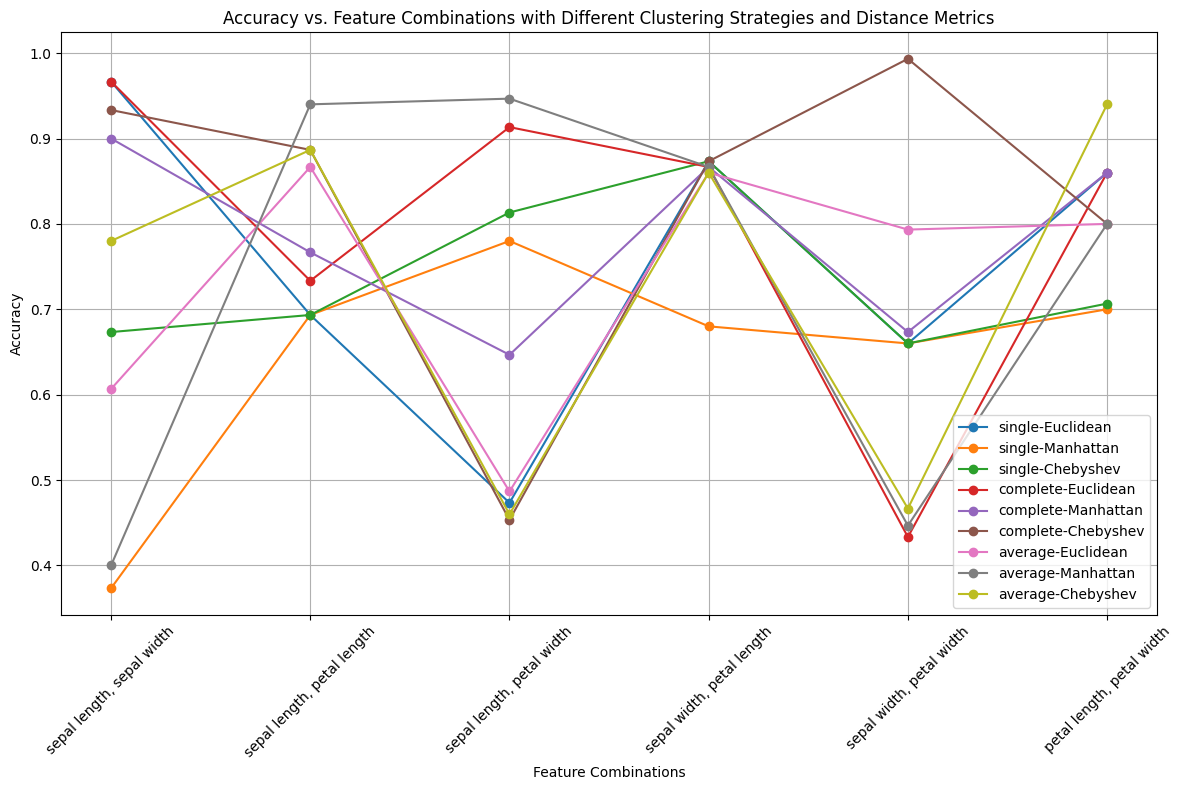

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# 提取的 Accuracy 数据
# accuracy_data_array = np.array([[0.96666667, 0.69333333, 0.47333333, 0.87333333, 0.66, 0.86],
#                                 [0.37333333, 0.69333333, 0.78, 0.68, 0.66, 0.7],
#                                 [0.67333333, 0.69333333, 0.81333333, 0.87333333, 0.66, 0.70666667],
#                                 [0.96666667, 0.73333333, 0.91333333, 0.86666667, 0.43333333, 0.86],
#                                 [0.9, 0.76666667, 0.64666667, 0.86666667, 0.67333333, 0.86],
#                                 [0.93333333, 0.88666667, 0.45333333, 0.87333333, 0.99333333, 0.8],
#                                 [0.60666667, 0.86666667, 0.48666667, 0.86, 0.79333333, 0.8],
#                                 [0.4, 0.94, 0.94666667, 0.86666667, 0.44666667, 0.8],
#                                 [0.78, 0.88666667, 0.46, 0.86, 0.46666667, 0.94]])

# 每种特征的组合标签
feature_labels = ['sepal length, sepal width', 'sepal length, petal length', 'sepal length, petal width',
                  'sepal width, petal length', 'sepal width, petal width', 'petal length, petal width']

# 不同的 Cluster Strategy 和 Distance Metric 组合标签
strategy_metric_labels = ['single-Euclidean', 'single-Manhattan', 'single-Chebyshev',
                          'complete-Euclidean', 'complete-Manhattan', 'complete-Chebyshev',
                          'average-Euclidean', 'average-Manhattan', 'average-Chebyshev']

# 创建一个图形
plt.figure(figsize=(12, 8))

# 绘制折线图
for i in range(len(strategy_metric_labels)):
    plt.plot(feature_labels, accuracy_data_array[i], marker='o', label=strategy_metric_labels[i])

# 添加标题和标签
plt.title('Accuracy vs. Feature Combinations with Different Clustering Strategies and Distance Metrics')
plt.xlabel('Feature Combinations')
plt.ylabel('Accuracy')

# 添加图例
plt.legend(loc='lower right')

# 显示图形
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
